In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import os
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,f1_score
from sklearn.model_selection import train_test_split

from  data_utils import *
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Conv1D
from keras.models import Sequential, load_model

In [2]:
def _init_humidity():
    beta = pd.read_excel(io="数据集/基本数据/附件3、土壤湿度2022—2012年.xls")
    beta = beta.sort_values(by=['年份', '月份'], ascending=[False, False]).iloc[::-1]
    # beta.to_excel('beta.xls')
    # print(self.beta.columns)
    return beta

def _init_graze():
    graze_indensity = pd.read_excel(io='数据集/监测点数据/附件14：内蒙古自治区锡林郭勒盟典型草原不同放牧强度土壤碳氮监测数据集（2012年8月15日-2020年8月15日）/内蒙古自治区锡林郭勒盟典型草原不同放牧强度土壤碳氮监测数据集（2012年8月15日-2020年8月15日）.xlsx')
    # print(graze_indensity.columns)
    return graze_indensity

def _init_surface_emission():
    surface_emission = pd.read_excel(io='数据集/基本数据/附件4、土壤蒸发量2012—2022年.xls')
    surface_emission= surface_emission.sort_values(by=['年份', '月份'], ascending=[False, False]).iloc[::-1]
    # print(surface_emission.columns)
    return surface_emission


def _init_climate():
    file_path = "数据集/基本数据/附件8、锡林郭勒盟气候2012-2022"
    file_ls = [os.path.join(file_path,  file_name) for file_name in   os.listdir(file_path)]
    climate  = pd.read_excel(io = file_ls[0])
    for i,value in enumerate(file_ls):
        if i!=0:
            new_sheet = pd.read_excel(io = value)
            climate = pd.concat((climate, new_sheet))
    # climate.to_excel('climate.xls')
    # print(self.climate.columns)
    return climate

def _init_ndvi():
    ndvi = pd.read_excel(io='数据集/基本数据/附件6、植被指数-NDVI2012-2022年.xls')
    ndvi= ndvi.sort_values(by=['年份', '月份'], ascending=[False, False]).iloc[::-1]
    return ndvi

def _init_runoff():
    runoff = pd.read_excel('数据集/基本数据/附件9、径流量2012-2022年.xlsx')
    runoff= runoff.sort_values(by=['年份', '月份'], ascending=[False, False]).iloc[::-1]
    return runoff

def _init_block_plant():
    """
    ['年份', '轮次', '处理', '日期', '植物种名', '植物群落功能群', '放牧小区Block', '重复', '营养苗',
   '生殖苗', '株/丛数', '丛幅1', '丛幅2', '鲜重(g)', '干重(g)', '平均每珠干重']
    :return:
    """
    plant = pd.read_excel('数据集/监测点数据/附件15：内蒙古自治区锡林郭勒盟典型草原轮牧放牧样地群落结构监测数据集（2016年6月-2020年9月）。/内蒙古自治区锡林郭勒盟典型草原轮牧放牧样地群落结构监测数据集（201.xlsx',sheet_name='2016-2020物种数据库')
    plant = plant.sort_values(by=['日期'], ascending=[False]).iloc[::-1]
    return plant



def calculate_icmax():
    LAI = pd.read_excel('数据集/基本数据/附件10、叶面积指数（LAI）2012-2022年.xls')
    LAI= LAI.sort_values(by=['年份', '月份'], ascending=[False, False]).iloc[::-1]
    LAIL = LAI['低层植被(LAIL,m2/m2)'][:123]   # 到202203截至
    LAIL = np.array(LAIL)
    icmax = 0.935+0.498*LAIL-0.00575*LAIL**2
    """
    ICstore,草地的植被直接决定放牧的强度，而植被的截流量能最好反映植被的生长能力，
    依照递推关系，放牧强度与植被的截流量存在正相关关系
    """
    Rcum = _init_climate().climate['降水量(mm)']
    return icmax

问题1.
从机理分析的角度，建立不同放牧策略（放牧方式和放牧强度）对锡林郭勒草原土壤物理性质（主要是土壤湿度）和植被生物量影响的数学模型。

2、土壤含水量-降水量-地表蒸发模型

![](1.jpg)


放牧强度对土地的物理性质,对土地的湿度的数学模型

分析： Gw>1, D<0

地表散发率E（a）， a = alpha Gw
先获取
humidity：土壤含水量
['月份', '年份', '经度(lon)', '纬度(lat)', '10cm湿度(kg/m2)', '40cm湿度(kg/m2)',
       '100cm湿度(kg/m2)', '200cm湿度(kg/m2)']


climate：气候降水
['站点号', '海拔高度(m)', '经度', '纬度', '年份', '月份', '平均气温(℃)', '平均最高气温(℃)',
       '平均最低气温(℃)', '最高气温极值(℃)', '最低气温极值(℃)', '平均气温≥18℃的天数', '平均气温≥35℃的天数',
       '平均气温≤0℃的天数', '平均露点温度(℃)', '降水量(mm)', '最大单日降水量(mm)', '降水天数',
       '平均海平面气压(hPa)', '最低海平面气压(hPa)', '平均站点气压(hPa)', '积雪深度(mm)', '平均能见度(km)',
       '最小能见度(km)', '最大能见度(km)', '平均风速(knots)', '平均最大持续风速(knots)',
       '单日最大平均风速(knots)', '平均最大瞬时风速(knots)', '最大瞬时风速极值(knots)']


graze:
['year', '放牧小区（plot）', '放牧强度（intensity）', 'SOC土壤有机碳', 'SIC土壤无机碳',
       'STC土壤全碳', '全氮N', '土壤C/N比', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10'],  132

surface_emission:
['月份', '年份', '经度(lon)', '纬度(lat)', '土壤蒸发量(W/m2)', '土壤蒸发量(mm)']


In [3]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps
        if end_ix > len(sequences)-1:
            break
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def init_dataset(dataset,n_steps=1):
    #dataset：数据标准化后的dataset
    # n_steps：分片大小，默认为1
    #依次为：[ '10cm湿度(kg/m2)', '40cm湿度(kg/m2)','100cm湿度(kg/m2)', '200cm湿度(kg/m2)', '土壤蒸发量(W/m2)', '土壤蒸发量(mm)','降水量(mm)', '平均风速(knots)']
    in_seq1= dataset[:,0].reshape((dataset.shape[0], 1))
    in_seq2= dataset[:,1].reshape((dataset.shape[0], 1))
    in_seq3= dataset[:,2].reshape((dataset.shape[0], 1))
    in_seq4= dataset[:,3].reshape((dataset.shape[0], 1))
    in_seq5= dataset[:,4].reshape((dataset.shape[0], 1))
    in_seq6= dataset[:,5].reshape((dataset.shape[0], 1))
    in_seq7= dataset[:,6].reshape((dataset.shape[0], 1))
    in_seq8= dataset[:,7].reshape((dataset.shape[0], 1))


    dataset = np.hstack((in_seq1, in_seq2, in_seq3, in_seq4,in_seq5,in_seq6,in_seq7,in_seq8))
    X, y = split_sequences(dataset, n_steps)
    print(X.shape, y.shape)
    return X, y

def lstmmodel_1(dataset,n_steps=1):
    X, y = init_dataset(dataset,n_steps)
    print(X.shape)
    n_features = X.shape[2]
    model = Sequential()
    model.add(Conv1D(60,kernel_size=3, activation='relu',padding='same',input_shape=(n_steps, n_features)))
    model.add(LSTM(300, activation='relu', return_sequences=True, input_shape=(60, n_features)))
    model.add(LSTM(300, activation='relu'))
    model.add(Dense(n_features*2, activation='relu'))
    model.add(Dense(n_features))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=200, verbose=2,shuffle=False)
    model.save('lstm_model.h5')
    last_input=np.array(dataset[-n_steps:,:])

    return X,y,last_input,n_features,n_steps

In [4]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
import seaborn as sns
sns.set_palette("husl") #设置所有图的颜色，使用hls色彩空间

In [5]:
class Q:
    def __init__(self,Q1:bool=False,Q2:bool=False,Q3:bool=False,Q4:bool=False,Q5:bool=False,Q6:bool=False):


        if Q1:
            self.question1()
        elif Q2:
            self.question2()
        elif Q3:
            self.question3()
        elif Q4:
            self.question4()
        elif Q5:
            self.question5()

    def question5(self):
        data5 = pd.read_excel('Q4_fig/result.xlsx')
        data5.sort_values(by=['年份','放牧小区（plot）'],inplace=True)
        data5.fillna(method='ffill',inplace=True)
        data5.reset_index(inplace=True,drop=True)


        ndvi = _init_ndvi()
        humidity,surface_emission=_init_humidity(),_init_surface_emission()
        runoff,climate = _init_runoff(),_init_climate()
        data_1 = pd.merge(humidity, surface_emission, on=('月份', '年份', '经度(lon)', '纬度(lat)')) # 123x10
        data_1 = pd.merge(data_1,ndvi)
        data_1 = pd.merge(data_1,runoff)
        data_1 = pd.merge(data_1,climate)
        del data_1['积雪深度(mm)']
        del data_1['平均最大瞬时风速(knots)']
        del data_1['最大瞬时风速极值(knots)']

        data=data_1[['月份', '年份','10cm湿度(kg/m2)','200cm湿度(kg/m2)', '植被指数(NDVI)','平均气温(℃)', '降水量(mm)','平均风速(knots)']]
        for i in data.columns[2:]:
            data[i]=(data[i]-data[i].min())/(data[i].max()-data[i].min())

        print(data)
        data5 = pd.merge(data5,data, on=('月份', '年份'))
        print(data5)


        data5=data5[['月份', '年份', '放牧小区（plot）', '放牧强度（intensity）', 'SOC土壤有机碳', 'SIC土壤无机碳','STC土壤全碳', '全氮N', '土壤C/N比', '10cm湿度(kg/m2)_y', '40cm湿度(kg/m2)','100cm湿度(kg/m2)', '200cm湿度(kg/m2)_y', '沙漠化程度指数', '植被指数(NDVI)', '平均气温(℃)','降水量(mm)', '平均风速(knots)','jiehe']]
        print(data5)

        data5['放羊数']=data5['放牧强度（intensity）'].map(
                        {
                            'NG':0,
                            'LGI':2,
                            'MGI':4,
                            'HGI':8
                        })
        X=data5[[ '降水量(mm)', 'jiehe']]
        y=data5['放羊数']
        # 拆分训练集和测试集
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)
        #线性回归
        model = LinearRegression()
        model.fit(x_train, y_train)
        print('线性回归')
        print(mean_absolute_percentage_error(model.predict(x_test),y_test))
        # Randomforest回归
        model = RandomForestRegressor()
        model.fit(x_train, y_train)
        print('Randomforest回归')
        print(mean_absolute_percentage_error(model.predict(x_test),y_test))
        # XGboost分类
        model = xgb.XGBRFRegressor()
        model.fit(x_train, y_train)
        print('XGboost回归')
        print(mean_absolute_percentage_error(model.predict(x_test),y_test))
        os.makedirs('Q5_fig',exist_ok=True)
        data5.to_excel('Q5_fig/data5.xlsx',index=None)



        for i in [300,600,900,1200]:
            ttemp=X.copy()
            ttemp[ 'jiehe']=0.5
            ttemp['降水量(mm)']=i
            print(model.predict(ttemp).mean())

        x1=[]
        y1=[]
        for i in range(1,100,5):
            ttemp=X.copy()
            ttemp[ 'jiehe']=i/100
            x1.append(i/100)
            ttemp['降水量(mm)']=300
            y1.append(model.predict(ttemp).mean())
        x2=[]
        y2=[]
        for i in range(1,100,5):
            ttemp=X.copy()
            ttemp[ 'jiehe']=i/100
            x2.append(i/100)
            ttemp['降水量(mm)']=600
            y2.append(model.predict(ttemp).mean())
        x3=[]
        y3=[]
        for i in range(1,100,5):
            ttemp=X.copy()
            ttemp[ 'jiehe']=i/100
            x3.append(i/100)
            ttemp['降水量(mm)']=900
            y3.append(model.predict(ttemp).mean())
        x4=[]
        y4=[]
        for i in range(1,100,5):
            ttemp=X.copy()
            ttemp[ 'jiehe']=i/100
            x4.append(i/100)
            ttemp['降水量(mm)']=1200
            y4.append(model.predict(ttemp).mean())
        plt.plot(x1,y1,label='300(mm)')
        plt.plot(x2,y2,label='600(mm)')
        plt.plot(x3,y3,label='900(mm)')
        plt.plot(x4,y4,label='1200(mm)')
        plt.xlabel( '沙漠化、板结化程度融合值')
        plt.ylabel( '放羊数目')

        plt.legend() # 显示图例

        plt.savefig('Q5_fig/放羊数目随沙漠化、板结化程度融合值变化情况.jpg')
        plt.show()


    def question4(self):
        data0 = self.data_preprocess_q4()
        X1 =data0[[ 'SOC土壤有机碳', 'SIC土壤无机碳', 'STC土壤全碳', '全氮N', '土壤C/N比']].values
        pca = PCA(n_components=1)   #降到1维
        pca.fit(X1)                  #训练
        newX1=pca.fit_transform(X1)   #降维后的数据
        # PCA(copy=True, n_components=2, whiten=False)
        print(pca.explained_variance_ratio_)  #输出贡献率
        X2 =data0[[ '10cm湿度(kg/m2)', '40cm湿度(kg/m2)', '100cm湿度(kg/m2)', '200cm湿度(kg/m2)']].values
        pca = PCA(n_components=1)   #降到1维
        pca.fit(X2)                  #训练
        newX2=pca.fit_transform(X2)   #降维后的数据
        print(pca.explained_variance_ratio_)  #输出贡献率

        data0['有机物含量']=newX1
        data0['土壤湿度']=newX2

        data0['土壤板结化指数']=1/2*data0['有机物含量']+1/2*data0['土壤湿度']
        i='土壤板结化指数'
        data0[i]=(data0[i]-data0[i].min())/(data0[i].max()-data0[i].min())
        data0['jiehe']=1/2*data0['土壤板结化指数']+1/2*data0['沙漠化程度指数']
        os.makedirs('Q4_fig',exist_ok=True)
        data0.to_excel('Q4_fig/result.xlsx')
        temp=data0[(data0['放牧强度（intensity）']=='NG')&(data0['放牧小区（plot）']=='G21')]
        """

        """
        print(temp)

    def question3(self):
        """问题3.从机理分析的角度，建立不同放牧策略（放牧方式和放牧强度）
        对锡林郭勒草原土壤化学性质影响的数学模型。
        并请结合附件14中数据预测锡林郭勒草原监测样地(12个放牧小区)
        在不同放牧强度下2022年土壤同期有机碳、无机碳、全N、土壤C/N比等值,并完成下表。"""

        df = self.data_preprocess_q3()
        predict = []
        predict_class = [(0,'G17'),(0,'G19'),(0,'G21'),(1,'G6'),(1,'G12'),(1,'G18'),
                        (2,'G8'),(2,'G11'),(2,'G16'),(3,'G9'),(3,'G13'),(3,'G20')]
        for value in predict_class:
            pred = self.plot_graze_block_q3(df,str(value[0]),value[1])
            predict.append(pred)
        with open("Q3_fig/result.csv",'w') as csvfile:
                csvfile.write(str(predict))


    def score(self,y_true, y_pre):
        # MSE
        print("MAPE :")
        print(mean_absolute_percentage_error(y_true, y_pre))
        # RMSE
        print("RMSE :")
        print(np.sqrt(metrics.mean_squared_error(y_true, y_pre)))
        # MAE
        print("MAE :")
        print(metrics.mean_absolute_error(y_true, y_pre))
        # # R2
        # print("R2 :")
        # print(np.abs(r2_score(y_true,y_pre)))

    def question2(self):
        '''联立13份数据，每月一个模型，外加一个总的模型'''
        data, month_data = self.data_preprocess_q2()
        data_1 = data.astype('float32')
        scaler = MinMaxScaler(feature_range=(0, 1))
        '''总数据模型'''
        dataset=scaler.fit_transform(data_1)
        X,y,last_input,n_features,n_steps=lstmmodel_1(dataset, n_steps=3)
        testPredict,testY=self.Predict_RMSE_BA(X,y,scaler)
        y_pre=self.Predict_future_plot(21,last_input,n_features,n_steps,scaler,testPredict,testY)
        self.predict_plot(y_pre)

    def plot_graze_block_q3(self, data, intensity,plot):
        """
        ['放牧强度','放牧小区Block','年份','SOC土壤有机碳', 'SIC土壤无机碳', 'STC土壤全碳', '全氮N',
       '土壤C/N比','土壤蒸发量(W/m2)','降水量(mm)','100cm湿度(kg/m2)']

        :param data: dataframe
        :param plot: block
        :param intensity: 0-3
        :return:
        """
        ppp=str(plot)+' '+intensity

        # print(data[(data['放牧小区Block']==plot)])
        temp=data[(data['放牧小区Block']==plot)&(data['放牧强度']==int(intensity))]

        temp.reset_index(inplace=True,drop=True)
        temp=temp.groupby('年份').mean()
        temp.reset_index(inplace=True,drop=False)
        os.makedirs('Q3_fig',exist_ok=True)
        for i in [ 'SOC土壤有机碳', 'SIC土壤无机碳', 'STC土壤全碳', '全氮N', '土壤C/N比']:
            plt.plot(temp['年份'].values,temp[i].values,label=i)
            plt.legend()
            plt.xlabel( '时间')
            plt.ylabel( '变量')
            plt.title( '2012~2020 %s 土壤化学性质 情况'%ppp)
            plt.savefig('Q3_fig/2012~2022 %s土壤化学性质 情况.jpg'%ppp)

        dataset=temp[[ 'SOC土壤有机碳', 'SIC土壤无机碳', 'STC土壤全碳', '全氮N',
                        '土壤C/N比','土壤蒸发量(W/m2)','降水量(mm)','100cm湿度(kg/m2)']]
        print(dataset)
        scaler = MinMaxScaler(feature_range=(0, 1))
        '''总数据模型'''

        dataset=scaler.fit_transform(dataset)
        X,y,last_input,n_features,n_steps=lstmmodel_1(dataset,n_steps=1)
        testPredict,testY=self.Predict_RMSE_BA_q3(X,y,scaler,ppp)
        y_pre=self.Predict_future_plot(1,last_input,n_features,n_steps,scaler,testPredict,testY)
        return y_pre


    def Predict_future_plot(self,predict_forword_number,x_input,n_features,n_steps,scaler,testPredict,testY):
        """

        :param predict_forword_number: 需要预测的数据量
        :param x_input: 输入最后的数据
        :param n_features: 特征量个数
        :param n_steps: 步伐
        :param scaler:
        :param testPredict:
        :param testY:
        :return: np.array
        """
        model=load_model('lstm_model.h5')
        predict_list=x_input.tolist() # 3,8

        while len(predict_list) < predict_forword_number+n_steps:
            temp = predict_list[-n_steps:]
            x_input = np.array(temp, dtype=np.float32)
            x_input = x_input.reshape(1,n_steps,-1)

            yhat = model.predict(x_input, verbose=0)
            yhat = yhat.reshape(-1).tolist()
            predict_list.append(yhat)

        Predict_forward = scaler.inverse_transform(np.array([np.array(i).reshape(-1,1)[:,0].tolist() for i in predict_list]))
        pred = Predict_forward[n_steps:,:]
        return pred


    def question1(self):
        data, data_0, data_1, data_0_notOneHot = self.data_preprocess_q1()
        feature_names_all = [ 'SOC土壤有机碳', 'SIC土壤无机碳', 'STC土壤全碳', '全氮N', '土壤C/N比',
       '鲜重(g)', '干重(g)',  '10cm湿度(kg/m2)', '200cm湿度(kg/m2)', '土壤蒸发量(W/m2)',
       '径流量(m3/s)', '植被指数(NDVI)', '平均气温(℃)', '降水量(mm)', '平均风速(knots)']
        feature_names_physic = ['SOC土壤有机碳', 'SIC土壤无机碳', 'STC土壤全碳', '全氮N', '土壤C/N比','10cm湿度(kg/m2)', '200cm湿度(kg/m2)', '土壤蒸发量(W/m2)']
        feature_names_bio = [ '株/丛数','鲜重(g)', '干重(g)', '植物功能群__AB', '植物功能群__PB', '植物功能群__PF','植物功能群__PR',  '土壤蒸发量(W/m2)','径流量(m3/s)', '植被指数(NDVI)']

        target_names = '放牧强度'
        Y = data[target_names]


        self.model_dtree(data[feature_names_physic],Y,feature_names_physic, target_names,"physic")
        self.model_dtree(data[feature_names_bio],Y,feature_names_bio, target_names,"bio")
        self.model_dtree(data[feature_names_all], Y, feature_names_all, target_names,'all')
        # self.model_tsne(data[feature_names],Y)



    def model_tsne(self, X, Y):
        from sklearn.manifold import  TSNE
        tsne = TSNE(n_components=3,verbose=1,perplexity=40,n_iter=300)

        tsne_result = tsne.fit(X, Y)
        tsne_result = np.array(tsne_result)
        plt.scatter(tsne_result[:,0],tsne_result[: ,1],c = Y)
        plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
        plt.title('T-SNE')
        plt.savefig('temp_img/tsne.jpg')
        plt.show()

    def model_dtree(self,X,Y, feature_names, target_names, save_name, features_nums = 6):
        sort_num = features_nums
        from sklearn import  tree
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=12)
        dtree = tree.DecisionTreeClassifier()
        dtree.fit(x_train, y_train)
        with open(f'Dot/dtree_{save_name}_q1.svg','w') as f: # svg格式防止中文乱码
            tree.export_graphviz(dtree,f,feature_names = feature_names,class_names = target_names)
        print('决策树分类')
        print(classification_report(dtree.predict(x_test),y_test))


        '''最重要的特征'''
        dtree_best_importance = dtree.feature_importances_
        important_feature = list(dtree_best_importance)
        ls = [[x,y] for x,y in zip(feature_names, important_feature)]
        ls.sort(key=lambda x: x[1], reverse=True)

        ls = np.array(ls)
        value_x = [round(float(x),3) for x in ls[:sort_num,1]]
        with open(f'temp_img/importance_features_{save_name}_q1.csv','w') as csvfile:
            csvfile.write(str(value_x))
        plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
        plt.barh(range(sort_num),value_x,tick_label = ls[:sort_num,0])
        plt.savefig(f'temp_img/importance_features_{save_name}_q1')
        plt.show()



    def data_analysis_and_3sigma(self, data):
        """
        3σ法又称为标准差法。标准差本身可以体现因子的离散程度，是基于因子的平均值 X _ m e a n X\_meanX_mean而定的。在离群值处理过程中，可通过用X _ m e a n ± n ∗ σ X\_mean±n*\sigmaX_mean±n∗σ来衡量因子与平均值的距离。
        标准差法处理的逻辑与MAD法类似:
        第一步：计算出因子的平均值与标准差
        第二步：确认参数 n（这里选定 n = 3）
        第三步：确认因子值的合理范围为[ X _ m e d i a n − n ∗ σ , X _ m e d i a n + n ∗ σ ] [X\_median-n*\sigma,X\_median+n*\sigma][X_median−n∗σ,X_median+n∗σ]，并对因子值作如下的调整：超出最大值的用最大值代替，小于最小值的用最小值代替。
        原文链接：https://blog.csdn.net/weixin_42432468/article/details/112474043
        :return:
        """
        for i,value in enumerate([ 'SOC土壤有机碳', 'SIC土壤无机碳', 'STC土壤全碳', '全氮N', '土壤C/N比', '株/丛数','鲜重(g)', '干重(g)', '10cm湿度(kg/m2)','40cm湿度(kg/m2)', '100cm湿度(kg/m2)', '200cm湿度(kg/m2)', '土壤蒸发量(W/m2)','径流量(m3/s)', '植被指数(NDVI)', '平均气温(℃)', '降水量(mm)', '平均风速(knots)']):
            # self.winsorize_plot(data[value],i,'处理前',value)
            sigma_winsorize = self.filter_extreme_3sigma(data[value],3,3)
            data[value] = sigma_winsorize
            # print('\n')
            # print (sigma_winsorize.min(),sigma_winsorize.max())
            # self.winsorize_plot(sigma_winsorize,i,'处理后',value)
        data.to_excel('all_data.xlsx')
        return data


    def data_preprocess_q2(self):
        """
        :return:     (11/10, 38) x 12 ,(123, 38)
        """
        climate, surface_emission =  _init_climate(), _init_surface_emission() # 天气，表面蒸发量
        humidity, ndvi, runoff = _init_humidity(),_init_ndvi(),_init_runoff() # 土壤湿度10cm，40cm，100cm, 植物NDVI ， 径流量

        data_1 = pd.merge(humidity, surface_emission, on=('月份', '年份', '经度(lon)', '纬度(lat)')) # 123x10
        data_1 = pd.merge(data_1,ndvi)
        data_1 = pd.merge(data_1,runoff)
        data_1 = pd.merge(data_1,climate)  # (123, 41)
        feature_names = [ '月份', '年份','10cm湿度(kg/m2)', '40cm湿度(kg/m2)','100cm湿度(kg/m2)', '200cm湿度(kg/m2)',
                          '土壤蒸发量(W/m2)', '土壤蒸发量(mm)','降水量(mm)', '平均风速(knots)']
        data_1 = data_1[feature_names]

        month_data = []
        for i in range(1, 13):
            temp = data_1[data_1['月份']==i]
            temp=temp.sort_values('年份')
            temp.reset_index(inplace=True,drop=True)
            month_data.append(temp)

        del data_1['月份']
        del data_1['年份']

        return data_1, month_data
    def data_preprocess_q3(self):
        """
        ['年份', '放牧小区Block', '放牧强度', 'SOC土壤有机碳', 'SIC土壤无机碳', 'STC土壤全碳', '全氮N',
       '土壤C/N比', '株/丛数', '鲜重(g)', '干重(g)', 'plot__G11', 'plot__G12',
       'plot__G13', 'plot__G16', 'plot__G17', 'plot__G18', 'plot__G19',
       'plot__G20', 'plot__G21', 'plot__G6', 'plot__G8', 'plot__G9', '轮次__牧前',
       '轮次__第一轮牧后', '轮次__第三轮牧后', '轮次__第二轮牧后', '轮次__第四轮牧后', '放牧方式__中牧（6天）',
       '放牧方式__无牧（0天）', '放牧方式__轻牧（3天）', '放牧方式__重牧（12天）', '植物功能群__AB',
       '植物功能群__PB', '植物功能群__PF', '植物功能群__PR', '月份', '10cm湿度(kg/m2)',
       '40cm湿度(kg/m2)', '100cm湿度(kg/m2)', '200cm湿度(kg/m2)', '土壤蒸发量(W/m2)',
       '径流量(m3/s)', '植被指数(NDVI)', '平均气温(℃)', '降水量(mm)', '平均风速(knots)']
        """
        df = pd.read_csv('temp_xlsx/df.csv')
        feature_names = ['放牧强度','放牧小区Block','年份','SOC土壤有机碳', 'SIC土壤无机碳', 'STC土壤全碳', '全氮N',
       '土壤C/N比','土壤蒸发量(W/m2)','降水量(mm)','100cm湿度(kg/m2)']
        df = df[feature_names]
        return df
    def data_preprocess_q4(self):

        climate, surface_emission =  _init_climate(), _init_surface_emission() # 天气，表面蒸发量
        humidity, ndvi, runoff = _init_humidity(),_init_ndvi(),_init_runoff() # 土壤湿度10cm，40cm，100cm, 植物NDVI ， 径流量
        graze_intensity, block_plant = _init_graze(), _init_block_plant()  # 放牧强度与土壤CN元素含量
        data_1 = pd.merge(humidity, surface_emission, on=('月份', '年份', '经度(lon)', '纬度(lat)')) # 123x10
        data_1 = pd.merge(data_1,ndvi)
        data_1 = pd.merge(data_1,runoff)
        data_1 = pd.merge(data_1,climate)
        del data_1['积雪深度(mm)']
        del data_1['平均最大瞬时风速(knots)']
        del data_1['最大瞬时风速极值(knots)']
        data=data_1[['月份', '年份','10cm湿度(kg/m2)','200cm湿度(kg/m2)', '植被指数(NDVI)','平均气温(℃)', '降水量(mm)','平均风速(knots)']]
        for i in data.columns[2:]:
            data[i]=(data[i]-data[i].min())/(data[i].max()-data[i].min())
        data[ '10cm湿度(kg/m2)']=1/3*data[ '10cm湿度(kg/m2)']
        data[ '200cm湿度(kg/m2)']=1/3*data[ '200cm湿度(kg/m2)']
        data[ '植被指数(NDVI)']=1/3*data[ '植被指数(NDVI)']
        data[ '平均气温(℃)']=1/3*data[ '平均气温(℃)']
        data[ '降水量(mm)']=1/3*data[ '降水量(mm)']
        data[ '平均风速(knots)']=1/3*data[ '平均风速(knots)']

        pca1 = PCA(n_components=1)   #降到1维
        X1 = data[['平均气温(℃)','降水量(mm)','平均风速(knots)']]
        X2 = data[['10cm湿度(kg/m2)','200cm湿度(kg/m2)','植被指数(NDVI)']]
        pca1.fit(X1)

        newX1=pca1.fit_transform(X1)   #降维后的数据
        print(pca1.explained_variance_ratio_)  #输出贡献率

        pca2 = PCA(n_components=1)   #降到1维
        pca2.fit(X2)#训练
        newX2=pca2.fit_transform(X2)   #降维后的数据
        print(pca2.explained_variance_ratio_)  #输出贡献率

        data['气象']=newX1
        data['地表']=newX2

        data['沙漠化程度指数']=data['气象']+data['地表']
        i='沙漠化程度指数'
        data[i]=(data[i]-data[i].min())/(data[i].max()-data[i].min())
        data=data.groupby('年份').mean()
        data.reset_index(inplace=True)
        data0 = pd.merge(graze_intensity,humidity,right_on=['年份'],left_on=['year'])

        data0=data0[['月份', '年份', '放牧小区（plot）', '放牧强度（intensity）', 'SOC土壤有机碳', 'SIC土壤无机碳',
       'STC土壤全碳', '全氮N', '土壤C/N比',
       '10cm湿度(kg/m2)', '40cm湿度(kg/m2)', '100cm湿度(kg/m2)', '200cm湿度(kg/m2)']]
        data0=pd.merge(data0,data[['沙漠化程度指数','年份']],on=['年份'])
        return data0








    def data_preprocess_q1(self):
        """
        建立不同放牧策略（放牧方式和放牧强度）对锡林郭勒草原土壤物理性质（主要是土壤湿度)和植被生物量影响的数学模型
        :return    dataframe

        ['年份', 'SOC土壤有机碳', 'SIC土壤无机碳', 'STC土壤全碳', '全氮N', '土壤C/N比', '株/丛数',
       '鲜重(g)', '干重(g)', 'plot__G11', 'plot__G12', 'plot__G13', 'plot__G16',
       'plot__G17', 'plot__G18', 'plot__G19', 'plot__G20', 'plot__G21',
       'plot__G6', 'plot__G8', 'plot__G9', '放牧强度', '轮次__牧前', '轮次__第一轮牧后',
       '轮次__第三轮牧后', '轮次__第二轮牧后', '轮次__第四轮牧后', '放牧方式__中牧（6天）', '放牧方式__无牧（0天）',
       '放牧方式__轻牧（3天）', '放牧方式__重牧（12天）', '植物功能群__AB', '植物功能群__PB', '植物功能群__PF',
       '植物功能群__PR', '月份', '10cm湿度(kg/m2)', '200cm湿度(kg/m2)', '土壤蒸发量(W/m2)',
       '径流量(m3/s)', '植被指数(NDVI)', '平均气温(℃)', '降水量(mm)', '平均风速(knots)']

        """
        graze_intensity, block_plant = _init_graze(), _init_block_plant()  # 放牧强度与土壤CN元素含量

        graze_intensity.rename(columns={'year':'年份','放牧小区（plot）':'放牧小区Block' }, inplace=True)
        """取元素含量和植物含量的交集"""
        data_0 = pd.merge(graze_intensity, block_plant, on=('年份','放牧小区Block'))
        data_0 = data_0[[ '年份', '放牧小区Block', '放牧强度（intensity）', 'SOC土壤有机碳', 'SIC土壤无机碳',
       'STC土壤全碳', '全氮N', '土壤C/N比',  '轮次', '处理',  '植物种名',
       '植物群落功能群',  '株/丛数','鲜重(g)', '干重(g)']]
        data_0['放牧强度']=data_0['放牧强度（intensity）'].map({'NG':0,'LGI':1,'MGI':2,'HGI':3})

        """--------------------------------------------------------------"""
        # print(df.isnull().sum()/df.shape[0])
        #     合并数据集，去除异常值(插值方法)
        for i in ['株/丛数', '鲜重(g)']:
            data_0[i]=data_0[i].fillna(data_0[i].mean())
        # print(data_0.isnull().sum()/data_0.shape[0])

        data_0_notOneHot = data_0
        data_0=pd.concat([data_0,pd.get_dummies(data_0['放牧小区Block'],prefix='plot_')],axis=1)
        data_0=pd.concat([data_0,pd.get_dummies(data_0['轮次'],prefix='轮次_')],axis=1)
        data_0=pd.concat([data_0,pd.get_dummies(data_0['处理'],prefix='放牧方式_')],axis=1)
        data_0=pd.concat([data_0,pd.get_dummies(data_0['植物群落功能群'],prefix='植物功能群_')],axis=1)

        data_0 = data_0[['年份', '放牧小区Block', '放牧强度','SOC土壤有机碳', 'SIC土壤无机碳', 'STC土壤全碳','全氮N', '土壤C/N比', '株/丛数', '鲜重(g)','干重(g)', 'plot__G11', 'plot__G12', 'plot__G13', 'plot__G16','plot__G17', 'plot__G18', 'plot__G19', 'plot__G20', 'plot__G21','plot__G6', 'plot__G8', 'plot__G9', '轮次__牧前', '轮次__第一轮牧后','轮次__第三轮牧后', '轮次__第二轮牧后', '轮次__第四轮牧后', '放牧方式__中牧（6天）', '放牧方式__无牧（0天）','放牧方式__轻牧（3天）', '放牧方式__重牧（12天）', '植物功能群__AB', '植物功能群__PB', '植物功能群__PF','植物功能群__PR']] # 去掉无用数据


        climate, surface_emission =  _init_climate(), _init_surface_emission() # 天气，表面蒸发量
        humidity, ndvi, runoff = _init_humidity(),_init_ndvi(),_init_runoff() # 土壤湿度10cm，40cm，100cm, 植物NDVI ， 径流量

        data_1 = pd.merge(humidity, surface_emission, on=('月份', '年份', '经度(lon)', '纬度(lat)')) # 123x10
        data_1 = pd.merge(data_1,ndvi)
        data_1 = pd.merge(data_1,runoff)
        data_1 = pd.merge(data_1,climate)
        data_1 = data_1[['月份', '年份','10cm湿度(kg/m2)','40cm湿度(kg/m2)','100cm湿度(kg/m2)','200cm湿度(kg/m2)','土壤蒸发量(W/m2)',
                         '径流量(m3/s)', '植被指数(NDVI)','平均气温(℃)', '降水量(mm)','平均风速(knots)']]

        """
        data_0 shape:(14297, 35)
        data_1 shape: (123, 10)
        合并后shape: (171564, 44)
        原因：按照年份相拼接，而土壤样本每年数据都是12份,故而这里合并后是  14297x12
        """
        df = pd.merge(data_0, data_1,on=['年份'])
        df = self.data_analysis_and_3sigma(df)

        os.makedirs('temp_xlsx',exist_ok=True)
        # df.to_excel("temp_xlsx/df.xlsx")
        # data_0.to_excel("temp_xlsx/data_0.xlsx")
        # data_1.to_excel("temp_xlsx/data_1.xlsx")
        # data_0_notOneHot.to_excel("temp_xlsx/data_0_notOneHot.xlsx")
        df.to_csv("temp_xlsx/df.csv")
        data_0.to_csv("temp_xlsx/data_0.csv")
        data_1.to_csv("temp_xlsx/data_1.csv")
        data_0_notOneHot.to_csv("temp_xlsx/data_0_notOneHot.csv")

        # np.save("temp_xlsx/df.npy",np.array(df))
        # np.save("temp_xlsx/data_0.npy",np.array(data_0))

        return df, data_0, data_1, data_0_notOneHot

    def winsorize_plot(self,data,i,flag,name):
        vertical_lines = self.data_vertical_lines(data)

        fig = plt.figure(figsize=(12,6))
        ax = fig.add_subplot(111)
        _df = ax.hist(data, 100,density=True)

        plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
        plt.title(f'{name}_{flag}')
        color_list = ['red','green','yellow','black','gold','gray']
        count = 0
        for value in vertical_lines:
            ax.bar(value, 0.1, width=0.05, color=color_list[count], alpha=1)
            count += 1
        plt.legend()
        plt.savefig(f'temp_img/{i}-{flag}.jpg')
        plt.show()

    def filter_extreme_3sigma(self,data,n=3,times=3):
        # times进行times次3sigma处理
        series = data.copy()
        for i in range(times):
            mean = series.mean()
            std = series.std()
            max_range = mean + n*std
            min_range = mean - n*std
            series = np.clip(series,min_range,max_range)
        df = pd.DataFrame(series)

        return df

    def data_vertical_lines(self, factor_data):
        data_mean = factor_data.mean()
        std = np.std(factor_data)
        std_up = data_mean+3*std
        std_low = data_mean-3*std
        quantile_low = np.percentile(factor_data, 2.5)
        quantile_high = np.percentile(factor_data, 97.5)
        vertical_lines = [std_up, std_low, quantile_high, quantile_low]
        return vertical_lines


    def predict_plot(self,pred_data):
        x = []
        for i in range(4,13):
            x.append(f"{i}")
        for i in range(1,13):
            x.append(f"_{i}")


        plt.plot(x, pred_data[:,0], color='red', label='10cm湿度')
        plt.xlabel( '月份')
        plt.ylabel( '湿度')
        plt.title( '2022~2023  10cm湿度')
        plt.legend() # 显示图例
        plt.savefig('Q2_fig/2022-2023 10cm湿度.jpg')
        plt.show()

        plt.plot(x, pred_data[:,1], color='red', label='40cm湿度')
        plt.xlabel( '月份')
        plt.ylabel( '湿度')
        plt.title( '2022~2023  40cm湿度')
        plt.legend() # 显示图例
        plt.savefig('Q2_fig/2022-2023 40cm湿度.jpg')
        plt.show()

        plt.plot(x, pred_data[:,2], color='red', label='100cm湿度')
        plt.xlabel( '月份')
        plt.ylabel( '湿度')
        plt.title( '2022~2023  100cm湿度')
        plt.legend() # 显示图例
        plt.savefig('Q2_fig/2022-2023 100cm湿度.jpg')
        plt.show()

        plt.plot(x, pred_data[:,3], color='red', label='200cm湿度')
        plt.xlabel( '月份')
        plt.ylabel( '湿度')
        plt.title( '2022~2023  200cm湿度')
        plt.legend() # 显示图例
        plt.savefig('Q2_fig/2022-2023 100cm湿度.jpg')
        plt.show()

        plt.plot(x, pred_data[:,0], color='blue', label='10cm')
        plt.plot(x, pred_data[:,1], color='blue', label='40cm')
        plt.plot(x, pred_data[:,2], color='red', label='100cm')
        plt.plot(x, pred_data[:,3], color='green', label='200cm')
        plt.xlabel( '月份')
        plt.ylabel( '湿度')
        plt.title( '2022~2023  湿度')
        plt.legend() # 显示图例
        plt.savefig('Q2_fig/2022-2023 湿度.jpg')
        plt.show()
        with open('Q2_fig/predict2022_2023.csv','w') as csvfile:
            csvfile.write(str(pred_data[:,:4]))

        plt.subplot(221)
        plt.plot(x, pred_data[:,0], color='blue', label='10cm')
        plt.ylabel( '湿度')
        plt.title( '2022~2023  湿度')
        plt.legend() # 显示图例
        plt.subplot(222)
        plt.plot(x, pred_data[:,1], color='blue', label='40cm')
        plt.title( '2022~2023  湿度')
        plt.legend() # 显示图例
        plt.subplot(223)
        plt.plot(x, pred_data[:,2], color='red', label='100cm')
        plt.ylabel( '湿度')
        plt.legend() # 显示图例
        plt.subplot(224)
        plt.plot(x, pred_data[:,3], color='green', label='200cm')
        plt.legend() # 显示图例
        plt.savefig('Q2_fig/2022-2023 湿度4图整合.jpg')
        plt.show()

    def Predict_RMSE_BA_q3(self,X,y,scaler, ppp):
        model=load_model('lstm_model.h5')
        trainPredict = model.predict(X)
        testPredict = scaler.inverse_transform(trainPredict)
        testY = scaler.inverse_transform(y)
        self.score(testY[:,0], testPredict[:,0])

        #'SOC土壤有机碳', 'SIC土壤无机碳', 'STC土壤全碳', '全氮N', '土壤C/N比'
        plt.plot(testY[:,0],color='yellow', label='observed data')
        plt.plot(testPredict[:,0], color='red', label='LSTM')
        plt.xlabel( '时间')
        #'SOC土壤有机碳', 'SIC土壤无机碳', 'STC土壤全碳', '全氮N', '土壤C/N比'
        plt.ylabel( 'SOC土壤有机碳')
        plt.title( '2012~2020 %s SOC土壤有机碳 情况'%ppp)

        plt.legend() # 显示图例

        plt.savefig('Q3_fig/2012~2020 %s  SOC土壤有机碳 情况.jpg'%ppp)
        plt.show()
        self.score(testY[:,1], testPredict[:,1])
        plt.plot(testY[:,1],color='yellow', label='observed data')
        plt.plot(testPredict[:,1], color='red', label='LSTM')
        plt.xlabel( '时间')
        #'SOC土壤有机碳', 'SIC土壤无机碳', 'STC土壤全碳', '全氮N', '土壤C/N比'
        plt.ylabel( 'SIC土壤无机碳')
        plt.title( '2012~2020 %s  SIC土壤无机碳 情况'%ppp)

        plt.legend() # 显示图例

        plt.savefig('Q3_fig/2012~2020 %s  SIC土壤无机碳 情况.jpg'%ppp)
        plt.show()
        self.score(testY[:,2], testPredict[:,2])
        plt.plot(testY[:,2],color='yellow', label='observed data')
        plt.plot(testPredict[:,2], color='red', label='LSTM')
        plt.xlabel( '时间')
        #'SOC土壤有机碳', 'SIC土壤无机碳', 'STC土壤全碳', '全氮N', '土壤C/N比'
        plt.ylabel( 'STC土壤全碳')
        plt.title( '2012~2020 %s  STC土壤全碳 情况'%ppp)

        plt.legend() # 显示图例

        plt.savefig('Q3_fig/2012~2020 %s  STC土壤全碳 情况.jpg'%ppp)
        plt.show()

        self.score(testY[:,3], testPredict[:,3])
        plt.plot(testY[:,3],color='yellow', label='observed data')
        plt.plot(testPredict[:,3], color='red', label='LSTM')
        plt.xlabel( '时间')
        #'SOC土壤有机碳', 'SIC土壤无机碳', 'STC土壤全碳', '全氮N', '土壤C/N比'
        plt.ylabel( '全氮N')
        plt.title( '2012~2020 %s  全氮N 情况'%ppp)

        plt.legend() # 显示图例

        plt.savefig('Q3_fig/2012~2020 %s  全氮N 情况.jpg'%ppp)
        plt.show()
        self.score(testY[:,4], testPredict[:,4])
        plt.plot(testY[:,4],color='yellow', label='observed data')
        plt.plot(testPredict[:,4], color='red', label='LSTM')
        plt.xlabel( '时间')
        #'SOC土壤有机碳', 'SIC土壤无机碳', 'STC土壤全碳', '全氮N', '土壤C/N比'
        plt.ylabel( '土壤C/N比')
        plt.title( '2012~2020 %s  土壤C/N比 情况'%ppp)

        plt.legend() # 显示图例

        plt.savefig('Q3_fig/2012~2020  %s 土壤CN比 情况.jpg'%ppp)
        plt.show()


        return testPredict,testY


    def Predict_RMSE_BA(self,X,y,scaler):

        model=load_model('lstm_model.h5')
        trainPredict = model.predict(X)
        testPredict = scaler.inverse_transform(trainPredict)
        testY = scaler.inverse_transform(y)
        self.score(testY[:,0], testPredict[:,0])
        os.makedirs('Q2_fig',exist_ok=True)

        #'10cm湿度(kg/m2)', '40cm湿度(kg/m2)','100cm湿度(kg/m2)', '200cm湿度(kg/m2)'
        plt.plot(testY[:,0],color='blue', label='observed data')
        plt.plot(testPredict[:,0], color='red', label='LSTM')
        plt.xlabel( '时间')
        plt.ylabel( '湿度')
        plt.title( '2012~2022 10cm湿度')
        plt.legend() # 显示图例
        plt.savefig('Q2_fig/2012~2022 1 月份10cm湿度.jpg')
        plt.show()

        #'10cm湿度(kg/m2)', '40cm湿度(kg/m2)','100cm湿度(kg/m2)', '200cm湿度(kg/m2)'
        self.score(testY[:,1], testPredict[:,1])
        plt.plot(testY[:,1],color='blue', label='observed data')
        plt.plot(testPredict[:,1], color='red', label='LSTM')
        plt.xlabel( '时间')
        plt.ylabel( '湿度')
        plt.title( '2012~2022  40cm湿度')
        plt.legend() # 显示图例
        plt.savefig('Q2_fig/2012~2022 1 月份 40cm湿度.jpg')
        plt.show()

        #'10cm湿度(kg/m2)', '40cm湿度(kg/m2)','100cm湿度(kg/m2)', '200cm湿度(kg/m2)'
        self.score(testY[:,2], testPredict[:,2])
        plt.plot(testY[:,2],color='blue', label='observed data')
        plt.plot(testPredict[:,2], color='red', label='LSTM')
        plt.xlabel( '时间')
        plt.ylabel( '湿度')
        plt.title( '2012~2022 100cm湿度')
        plt.legend() # 显示图例

        plt.savefig('Q2_fig/2012~2022 1 月份 100cm湿度.jpg')
        plt.show()


        #'10cm湿度(kg/m2)', '40cm湿度(kg/m2)','100cm湿度(kg/m2)', '200cm湿度(kg/m2)'
        self.score(testY[:,3], testPredict[:,3])
        plt.plot(testY[:,3],color='blue', label='observed data')
        plt.plot(testPredict[:,3], color='red', label='LSTM')
        plt.xlabel( '时间')
        plt.ylabel( '湿度')
        plt.title( '2012~2022  200cm湿度')
        plt.legend() # 显示图例
        plt.savefig('Q2_fig/2012~2022 1 月份 200cm湿度.jpg')
        plt.show()
        return testPredict,testY


决策树分类
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11120
           1       1.00      1.00      1.00     14344
           2       1.00      1.00      1.00     12925
           3       1.00      1.00      1.00     13081

    accuracy                           1.00     51470
   macro avg       1.00      1.00      1.00     51470
weighted avg       1.00      1.00      1.00     51470



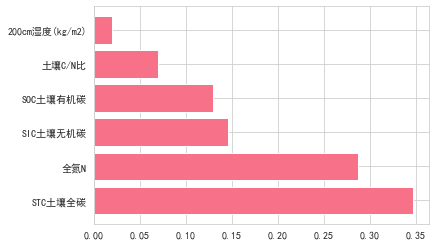

决策树分类
              precision    recall  f1-score   support

           0       0.95      0.96      0.95     10992
           1       0.91      0.94      0.93     13916
           2       0.90      0.89      0.89     13058
           3       0.92      0.89      0.90     13504

    accuracy                           0.92     51470
   macro avg       0.92      0.92      0.92     51470
weighted avg       0.92      0.92      0.92     51470



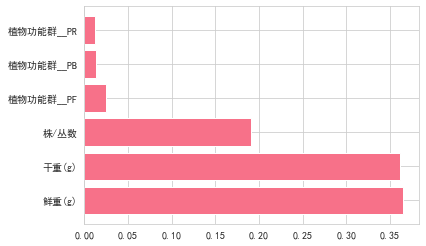

决策树分类
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11120
           1       1.00      1.00      1.00     14344
           2       1.00      1.00      1.00     12925
           3       1.00      1.00      1.00     13081

    accuracy                           1.00     51470
   macro avg       1.00      1.00      1.00     51470
weighted avg       1.00      1.00      1.00     51470



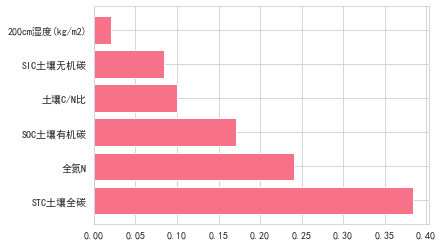

CPU times: total: 47.5 s
Wall time: 1min 24s


In [6]:
%%time
Q(Q1 = True)

(120, 3, 8) (120, 8)
(120, 3, 8)
Epoch 1/200
4/4 - 2s - loss: 0.1902 - 2s/epoch - 535ms/step
Epoch 2/200
4/4 - 0s - loss: 0.1797 - 51ms/epoch - 13ms/step
Epoch 3/200
4/4 - 0s - loss: 0.1656 - 53ms/epoch - 13ms/step
Epoch 4/200
4/4 - 0s - loss: 0.1527 - 53ms/epoch - 13ms/step
Epoch 5/200
4/4 - 0s - loss: 0.1450 - 55ms/epoch - 14ms/step
Epoch 6/200
4/4 - 0s - loss: 0.1299 - 57ms/epoch - 14ms/step
Epoch 7/200
4/4 - 0s - loss: 0.1071 - 55ms/epoch - 14ms/step
Epoch 8/200
4/4 - 0s - loss: 0.0869 - 56ms/epoch - 14ms/step
Epoch 9/200
4/4 - 0s - loss: 0.0729 - 52ms/epoch - 13ms/step
Epoch 10/200
4/4 - 0s - loss: 0.0633 - 52ms/epoch - 13ms/step
Epoch 11/200
4/4 - 0s - loss: 0.0566 - 50ms/epoch - 13ms/step
Epoch 12/200
4/4 - 0s - loss: 0.0526 - 56ms/epoch - 14ms/step
Epoch 13/200
4/4 - 0s - loss: 0.0486 - 66ms/epoch - 17ms/step
Epoch 14/200
4/4 - 0s - loss: 0.0469 - 53ms/epoch - 13ms/step
Epoch 15/200
4/4 - 0s - loss: 0.0452 - 54ms/epoch - 13ms/step
Epoch 16/200
4/4 - 0s - loss: 0.0438 - 56ms/epo

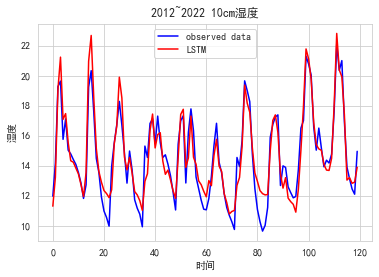

MAPE :
2.6598555967211723
RMSE :
1.4487807
MAE :
1.0944524


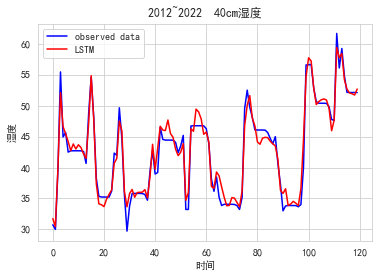

MAPE :
2.967965789139271
RMSE :
2.1174407
MAE :
1.6296996


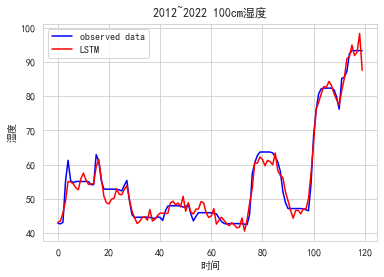

MAPE :
0.10921555804088712
RMSE :
0.22441813
MAE :
0.18236084


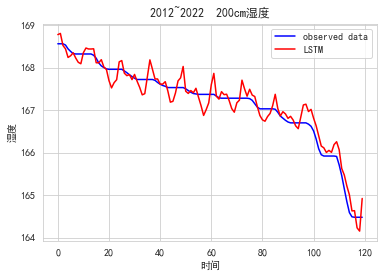

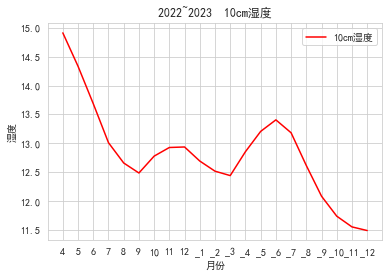

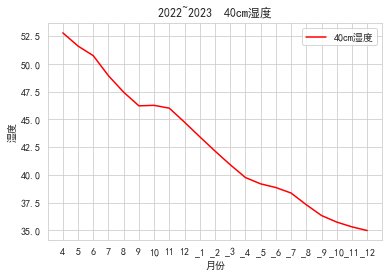

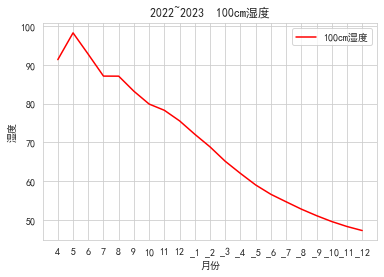

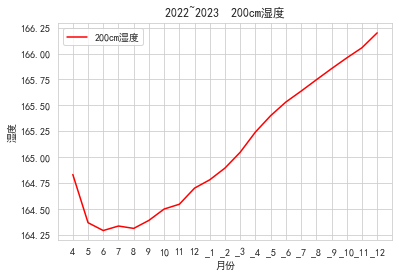

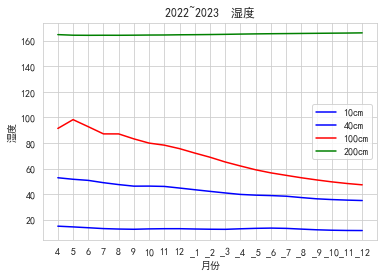

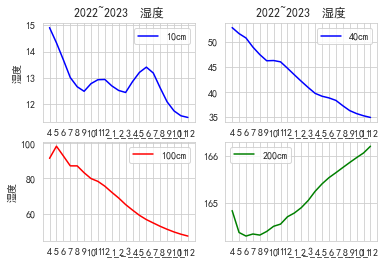

CPU times: total: 7.64 s
Wall time: 17.8 s


In [7]:
%%time
Q(Q2 = True)

    SOC土壤有机碳  SIC土壤无机碳    STC土壤全碳       全氮N     土壤C/N比  土壤蒸发量(W/m2)  \
0  15.679023  7.983333  23.662356  1.813318  14.102624     8.950833   
1  15.763244  7.833333  23.596577  1.971321  12.858514     8.682500   
2  16.858300  6.086750  22.945050  2.115200  10.847698    11.865000   

      降水量(mm)  100cm湿度(kg/m2)  
0   72.890627       46.701667  
1  105.982500       50.712500  
2   33.062500       60.183164  
(2, 1, 8) (2, 8)
(2, 1, 8)
Epoch 1/200
1/1 - 2s - loss: 0.4640 - 2s/epoch - 2s/step
Epoch 2/200
1/1 - 0s - loss: 0.4619 - 5ms/epoch - 5ms/step
Epoch 3/200
1/1 - 0s - loss: 0.4596 - 6ms/epoch - 6ms/step
Epoch 4/200
1/1 - 0s - loss: 0.4572 - 6ms/epoch - 6ms/step
Epoch 5/200
1/1 - 0s - loss: 0.4547 - 7ms/epoch - 7ms/step
Epoch 6/200
1/1 - 0s - loss: 0.4521 - 8ms/epoch - 8ms/step
Epoch 7/200
1/1 - 0s - loss: 0.4492 - 8ms/epoch - 8ms/step
Epoch 8/200
1/1 - 0s - loss: 0.4462 - 7ms/epoch - 7ms/step
Epoch 9/200
1/1 - 0s - loss: 0.4429 - 6ms/epoch - 6ms/step
Epoch 10/200
1/1 - 0s - loss: 0

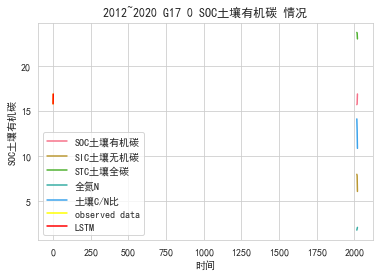

MAPE :
1.2540165609947653
RMSE :
0.125416367166708
MAE :
0.09602802530924404


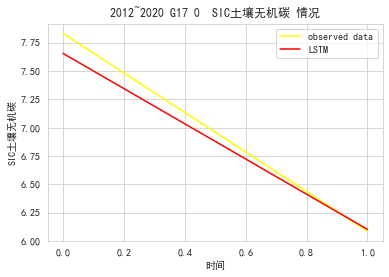

MAPE :
0.5341062665887101
RMSE :
0.1724221164428112
MAE :
0.12591544844308977


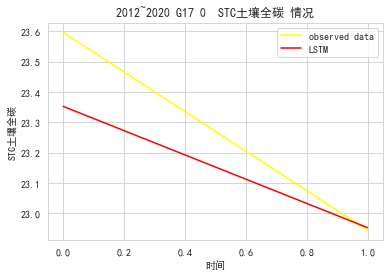

MAPE :
2.252154039840514
RMSE :
0.06192619497034386
MAE :
0.04444197167555497


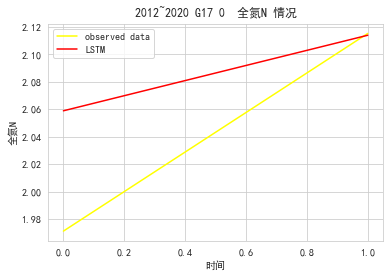

MAPE :
0.31344233769683927
RMSE :
0.03681715214935806
MAE :
0.03680495042940635


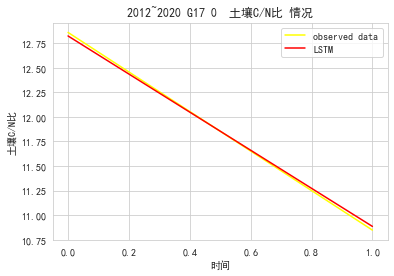

    SOC土壤有机碳  SIC土壤无机碳    STC土壤全碳       全氮N     土壤C/N比  土壤蒸发量(W/m2)  \
0  14.618971  6.675556  21.294526  1.803798  12.600770     8.950833   
1  17.112143  5.566667  22.678810  2.017754  11.782797     8.682500   
2  17.298500  4.301450  21.599950  2.198050   9.826869    11.865000   

      降水量(mm)  100cm湿度(kg/m2)  
0   72.890627       46.701667  
1  105.982500       50.712500  
2   33.062500       60.183164  
(2, 1, 8) (2, 8)
(2, 1, 8)
Epoch 1/200
1/1 - 2s - loss: 0.5051 - 2s/epoch - 2s/step
Epoch 2/200
1/1 - 0s - loss: 0.5023 - 6ms/epoch - 6ms/step
Epoch 3/200
1/1 - 0s - loss: 0.4999 - 6ms/epoch - 6ms/step
Epoch 4/200
1/1 - 0s - loss: 0.4975 - 7ms/epoch - 7ms/step
Epoch 5/200
1/1 - 0s - loss: 0.4948 - 5ms/epoch - 5ms/step
Epoch 6/200
1/1 - 0s - loss: 0.4915 - 5ms/epoch - 5ms/step
Epoch 7/200
1/1 - 0s - loss: 0.4880 - 8ms/epoch - 8ms/step
Epoch 8/200
1/1 - 0s - loss: 0.4842 - 7ms/epoch - 7ms/step
Epoch 9/200
1/1 - 0s - loss: 0.4800 - 7ms/epoch - 7ms/step
Epoch 10/200
1/1 - 0s - loss: 0

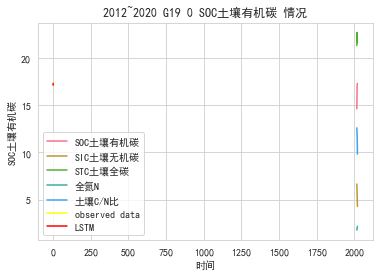

MAPE :
0.024861662297524675
RMSE :
0.0012292008762043861
MAE :
0.001222704950968545


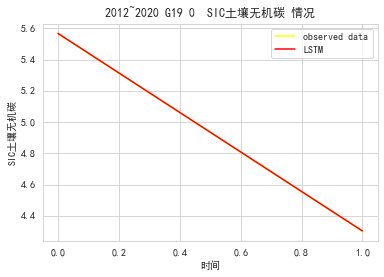

MAPE :
0.0012524420916277708
RMSE :
0.0003133223708624977
MAE :
0.0002733887990427064


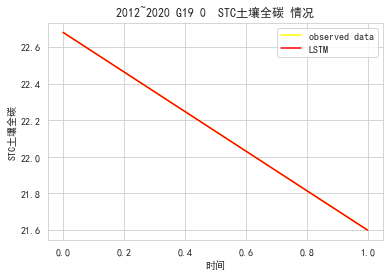

MAPE :
0.007971703161132652
RMSE :
0.00021148098344237452
MAE :
0.0001729342977216941


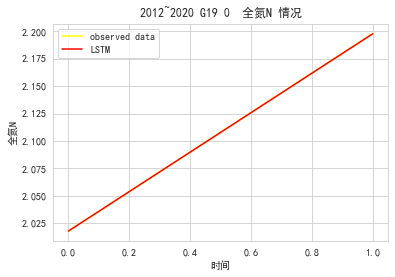

MAPE :
0.02721516484908759
RMSE :
0.0029049245638265277
MAE :
0.0028887881125809756


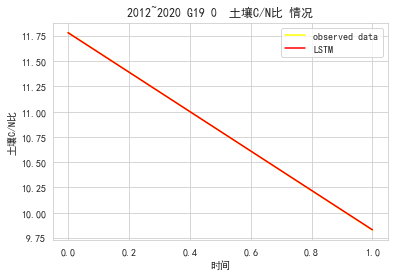

    SOC土壤有机碳  SIC土壤无机碳    STC土壤全碳       全氮N     土壤C/N比  土壤蒸发量(W/m2)  \
0  15.834895  6.233333  22.068228  1.855074  12.888815     8.950833   
1  18.032860  5.733333  23.766193  2.185436  11.483865     8.682500   
2  20.133500  4.064900  24.198400  2.431150   9.953479    11.865000   

      降水量(mm)  100cm湿度(kg/m2)  
0   72.890627       46.701667  
1  105.982500       50.712500  
2   33.062500       60.183164  
(2, 1, 8) (2, 8)
(2, 1, 8)
Epoch 1/200
1/1 - 2s - loss: 0.5115 - 2s/epoch - 2s/step
Epoch 2/200
1/1 - 0s - loss: 0.5084 - 7ms/epoch - 7ms/step
Epoch 3/200
1/1 - 0s - loss: 0.5055 - 6ms/epoch - 6ms/step
Epoch 4/200
1/1 - 0s - loss: 0.5025 - 7ms/epoch - 7ms/step
Epoch 5/200
1/1 - 0s - loss: 0.4994 - 7ms/epoch - 7ms/step
Epoch 6/200
1/1 - 0s - loss: 0.4961 - 7ms/epoch - 7ms/step
Epoch 7/200
1/1 - 0s - loss: 0.4925 - 6ms/epoch - 6ms/step
Epoch 8/200
1/1 - 0s - loss: 0.4887 - 9ms/epoch - 9ms/step
Epoch 9/200
1/1 - 0s - loss: 0.4845 - 7ms/epoch - 7ms/step
Epoch 10/200
1/1 - 0s - loss: 0

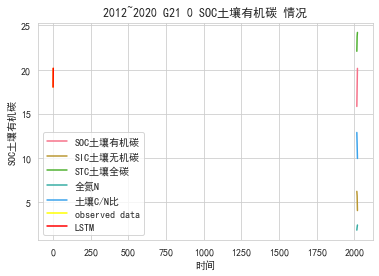

MAPE :
1.7406054583368573
RMSE :
0.10400253871452847
MAE :
0.09128706410725895


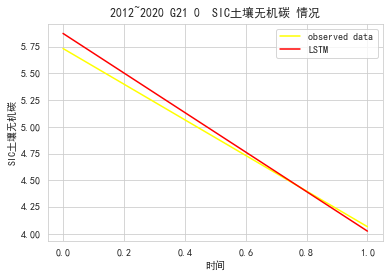

MAPE :
0.5417406256384086
RMSE :
0.12993572047748853
MAE :
0.12992577788036108


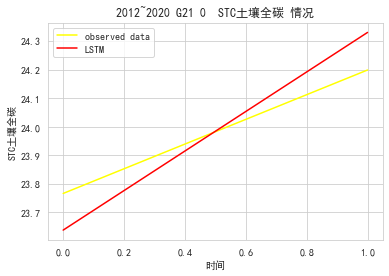

MAPE :
0.7599363115880896
RMSE :
0.019629076479078595
MAE :
0.017918425651391567


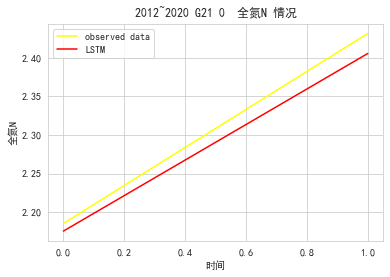

MAPE :
0.8047846309764253
RMSE :
0.08569872364858026
MAE :
0.08567314941149551


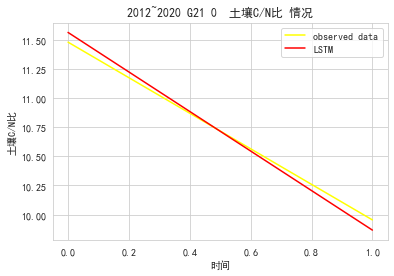

    SOC土壤有机碳  SIC土壤无机碳    STC土壤全碳       全氮N     土壤C/N比  土壤蒸发量(W/m2)  \
0  14.317466    6.3000  20.617466  1.812071  12.143385     8.950833   
1  14.799450    5.5000  20.299450  1.930055  10.994639     8.682500   
2  14.789650    3.0012  17.790850  2.016500   8.822638    11.865000   

      降水量(mm)  100cm湿度(kg/m2)  
0   72.890627       46.701667  
1  105.982500       50.712500  
2   33.062500       60.183164  
(2, 1, 8) (2, 8)
(2, 1, 8)
Epoch 1/200
1/1 - 2s - loss: 0.5106 - 2s/epoch - 2s/step
Epoch 2/200
1/1 - 0s - loss: 0.5068 - 5ms/epoch - 5ms/step
Epoch 3/200
1/1 - 0s - loss: 0.5029 - 6ms/epoch - 6ms/step
Epoch 4/200
1/1 - 0s - loss: 0.4990 - 7ms/epoch - 7ms/step
Epoch 5/200
1/1 - 0s - loss: 0.4947 - 5ms/epoch - 5ms/step
Epoch 6/200
1/1 - 0s - loss: 0.4902 - 6ms/epoch - 6ms/step
Epoch 7/200
1/1 - 0s - loss: 0.4852 - 7ms/epoch - 7ms/step
Epoch 8/200
1/1 - 0s - loss: 0.4797 - 7ms/epoch - 7ms/step
Epoch 9/200
1/1 - 0s - loss: 0.4736 - 7ms/epoch - 7ms/step
Epoch 10/200
1/1 - 0s - loss: 0

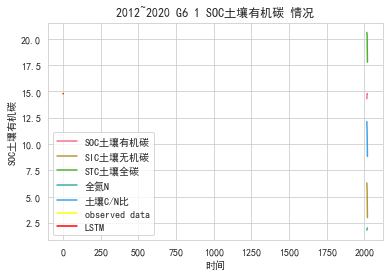

MAPE :
0.019580915525304866
RMSE :
0.0009815481222541025
MAE :
0.0008851093292236989


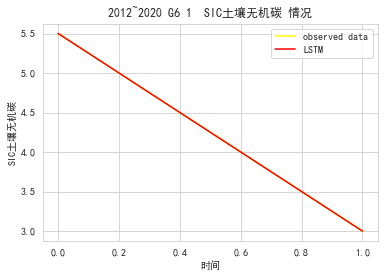

MAPE :
0.010512218525165085
RMSE :
0.002455586367021993
MAE :
0.00189014531802556


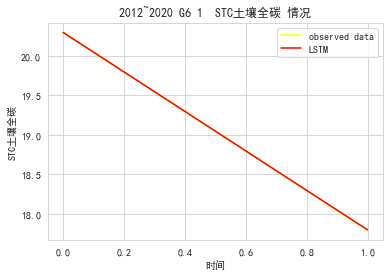

MAPE :
0.024005404248977076
RMSE :
0.0005995173745159864
MAE :
0.0004812956651039091


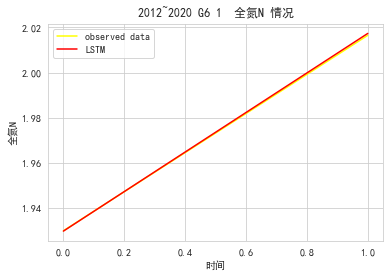

MAPE :
0.036625676027009994
RMSE :
0.003708980694802107
MAE :
0.003431140001795896


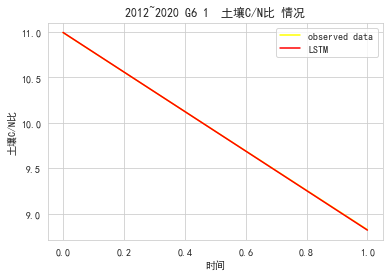

    SOC土壤有机碳  SIC土壤无机碳    STC土壤全碳       全氮N     土壤C/N比  土壤蒸发量(W/m2)  \
0  15.418321    5.2950  20.713321  1.840574  11.820231     8.950833   
1  14.919320    6.2500  21.169320  1.855670  11.910043     8.682500   
2  16.185800    3.8029  19.988700  1.944800  10.278023    11.865000   

      降水量(mm)  100cm湿度(kg/m2)  
0   72.890627       46.701667  
1  105.982500       50.712500  
2   33.062500       60.183164  
(2, 1, 8) (2, 8)
(2, 1, 8)
Epoch 1/200
1/1 - 2s - loss: 0.5068 - 2s/epoch - 2s/step
Epoch 2/200
1/1 - 0s - loss: 0.5050 - 7ms/epoch - 7ms/step
Epoch 3/200
1/1 - 0s - loss: 0.5029 - 6ms/epoch - 6ms/step
Epoch 4/200
1/1 - 0s - loss: 0.5007 - 5ms/epoch - 5ms/step
Epoch 5/200
1/1 - 0s - loss: 0.4985 - 7ms/epoch - 7ms/step
Epoch 6/200
1/1 - 0s - loss: 0.4963 - 7ms/epoch - 7ms/step
Epoch 7/200
1/1 - 0s - loss: 0.4938 - 9ms/epoch - 9ms/step
Epoch 8/200
1/1 - 0s - loss: 0.4913 - 7ms/epoch - 7ms/step
Epoch 9/200
1/1 - 0s - loss: 0.4885 - 6ms/epoch - 6ms/step
Epoch 10/200
1/1 - 0s - loss: 0

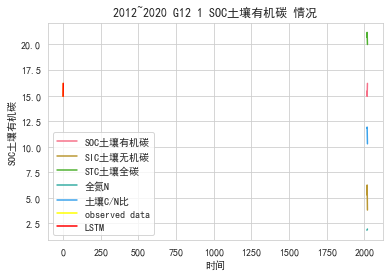

MAPE :
0.8291514857918902
RMSE :
0.04443498852377743
MAE :
0.04242428321838365


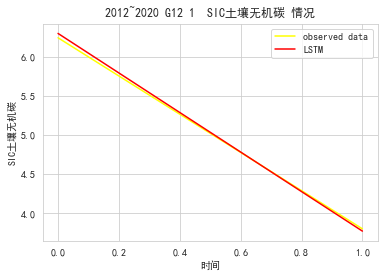

MAPE :
0.32116511428521716
RMSE :
0.06988748160829905
MAE :
0.0653258127212375


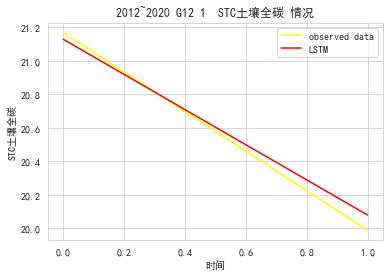

MAPE :
0.045494499364341454
RMSE :
0.0009295695457294292
MAE :
0.0008554989556466275


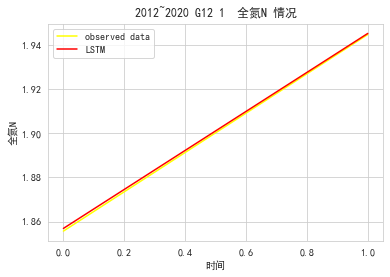

MAPE :
0.7713937785499595
RMSE :
0.10337884142532353
MAE :
0.0889859647218687


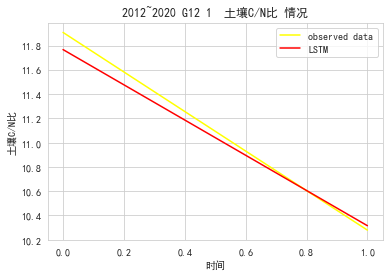

    SOC土壤有机碳  SIC土壤无机碳    STC土壤全碳       全氮N     土壤C/N比  土壤蒸发量(W/m2)  \
0  16.624699  7.694444  24.319144  1.899060  13.570944     8.950833   
1  17.091615  8.733333  25.824948  2.069111  13.305531     8.682500   
2  19.306000  7.207300  26.513300  2.257150  11.746362    11.865000   

      降水量(mm)  100cm湿度(kg/m2)  
0   72.890627       46.701667  
1  105.982500       50.712500  
2   33.062500       60.183164  
(2, 1, 8) (2, 8)
(2, 1, 8)
Epoch 1/200
1/1 - 2s - loss: 0.5345 - 2s/epoch - 2s/step
Epoch 2/200
1/1 - 0s - loss: 0.5314 - 7ms/epoch - 7ms/step
Epoch 3/200
1/1 - 0s - loss: 0.5287 - 8ms/epoch - 8ms/step
Epoch 4/200
1/1 - 0s - loss: 0.5258 - 6ms/epoch - 6ms/step
Epoch 5/200
1/1 - 0s - loss: 0.5227 - 6ms/epoch - 6ms/step
Epoch 6/200
1/1 - 0s - loss: 0.5193 - 7ms/epoch - 7ms/step
Epoch 7/200
1/1 - 0s - loss: 0.5157 - 7ms/epoch - 7ms/step
Epoch 8/200
1/1 - 0s - loss: 0.5118 - 6ms/epoch - 6ms/step
Epoch 9/200
1/1 - 0s - loss: 0.5075 - 6ms/epoch - 6ms/step
Epoch 10/200
1/1 - 0s - loss: 0

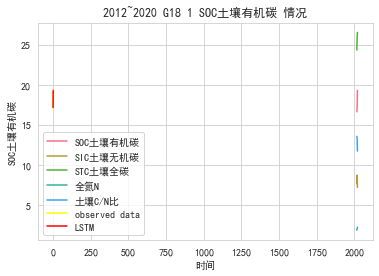

MAPE :
0.08951902867773956
RMSE :
0.009734416429597742
MAE :
0.007646288172403537


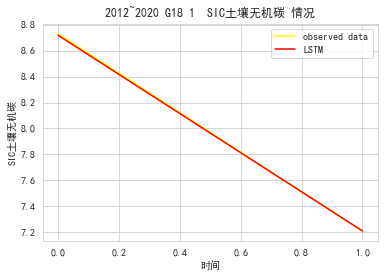

MAPE :
0.04844742611103671
RMSE :
0.015579236446814464
MAE :
0.012554754002890078


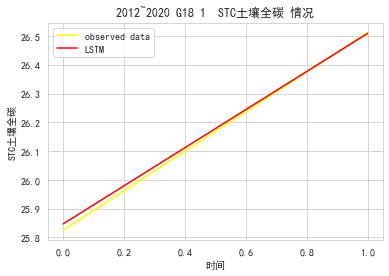

MAPE :
0.0598059519418591
RMSE :
0.0015426595271228897
MAE :
0.0012520672559723778


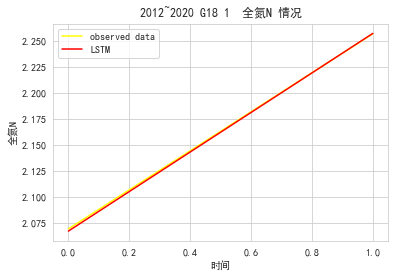

MAPE :
0.03832802541613699
RMSE :
0.0054273894679699375
MAE :
0.004924371994435184


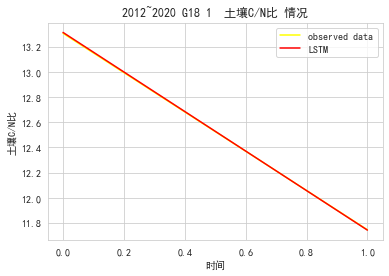

    SOC土壤有机碳  SIC土壤无机碳    STC土壤全碳       全氮N     土壤C/N比  土壤蒸发量(W/m2)  \
0  14.028019  6.700000  20.728019  1.833418  11.945595     8.950833   
1  14.581394  2.816667  17.398060  1.865450   9.564032     8.682500   
2  14.442100  1.885500  16.327600  1.941050   8.411736    11.865000   

      降水量(mm)  100cm湿度(kg/m2)  
0   72.890627       46.701667  
1  105.982500       50.712500  
2   33.062500       60.183164  
(2, 1, 8) (2, 8)
(2, 1, 8)
Epoch 1/200
1/1 - 2s - loss: 0.3709 - 2s/epoch - 2s/step
Epoch 2/200
1/1 - 0s - loss: 0.3689 - 7ms/epoch - 7ms/step
Epoch 3/200
1/1 - 0s - loss: 0.3669 - 8ms/epoch - 8ms/step
Epoch 4/200
1/1 - 0s - loss: 0.3649 - 5ms/epoch - 5ms/step
Epoch 5/200
1/1 - 0s - loss: 0.3627 - 5ms/epoch - 5ms/step
Epoch 6/200
1/1 - 0s - loss: 0.3605 - 8ms/epoch - 8ms/step
Epoch 7/200
1/1 - 0s - loss: 0.3580 - 7ms/epoch - 7ms/step
Epoch 8/200
1/1 - 0s - loss: 0.3553 - 6ms/epoch - 6ms/step
Epoch 9/200
1/1 - 0s - loss: 0.3522 - 6ms/epoch - 6ms/step
Epoch 10/200
1/1 - 0s - loss: 0

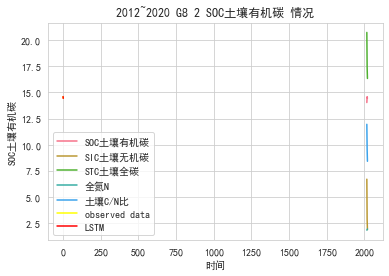

MAPE :
14.113938829073208
RMSE :
0.331808718349971
MAE :
0.3283203751246133


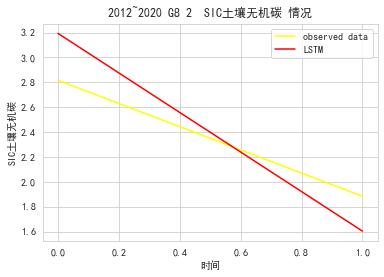

MAPE :
0.6467930700908772
RMSE :
0.10899373033776504
MAE :
0.10898921772640158


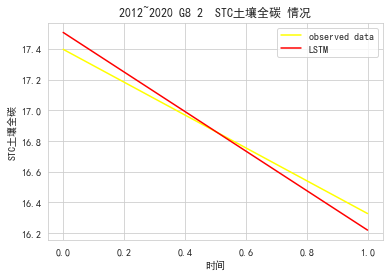

MAPE :
0.09020726430635052
RMSE :
0.0017368597102264233
MAE :
0.0017101680199307356


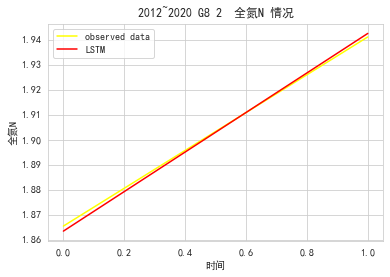

MAPE :
0.2636831794624555
RMSE :
0.025340553975693913
MAE :
0.024103489483714213


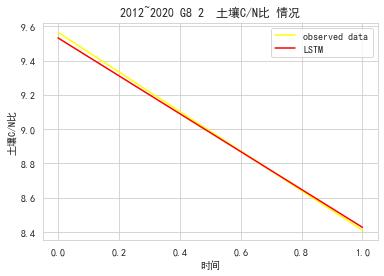

    SOC土壤有机碳  SIC土壤无机碳    STC土壤全碳       全氮N     土壤C/N比  土壤蒸发量(W/m2)  \
0  13.270261  5.484444  18.754705  1.739910  11.223092     8.950833   
1  15.164307  4.300000  19.464307  1.923908  10.399164     8.682500   
2  14.744350  3.353600  18.097950  1.961450   9.226822    11.865000   

      降水量(mm)  100cm湿度(kg/m2)  
0   72.890627       46.701667  
1  105.982500       50.712500  
2   33.062500       60.183164  
(2, 1, 8) (2, 8)
(2, 1, 8)
Epoch 1/200
1/1 - 2s - loss: 0.4955 - 2s/epoch - 2s/step
Epoch 2/200
1/1 - 0s - loss: 0.4930 - 5ms/epoch - 5ms/step
Epoch 3/200
1/1 - 0s - loss: 0.4908 - 6ms/epoch - 6ms/step
Epoch 4/200
1/1 - 0s - loss: 0.4885 - 6ms/epoch - 6ms/step
Epoch 5/200
1/1 - 0s - loss: 0.4860 - 6ms/epoch - 6ms/step
Epoch 6/200
1/1 - 0s - loss: 0.4834 - 5ms/epoch - 5ms/step
Epoch 7/200
1/1 - 0s - loss: 0.4806 - 7ms/epoch - 7ms/step
Epoch 8/200
1/1 - 0s - loss: 0.4776 - 7ms/epoch - 7ms/step
Epoch 9/200
1/1 - 0s - loss: 0.4744 - 5ms/epoch - 5ms/step
Epoch 10/200
1/1 - 0s - loss: 0

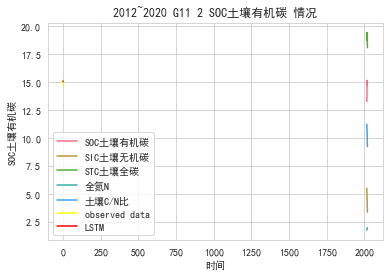

MAPE :
1.639597778572787
RMSE :
0.061674677932541846
MAE :
0.060041152763366856


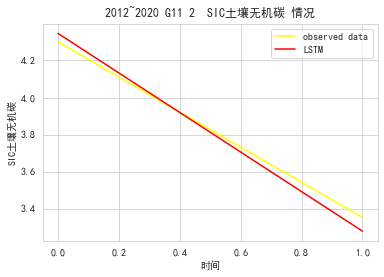

MAPE :
0.08267150787960303
RMSE :
0.020291518494977512
MAE :
0.015961835002904934


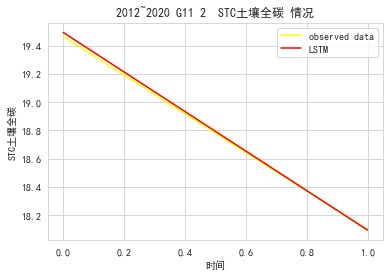

MAPE :
0.26277419058230195
RMSE :
0.005952714360562422
MAE :
0.00507431010802617


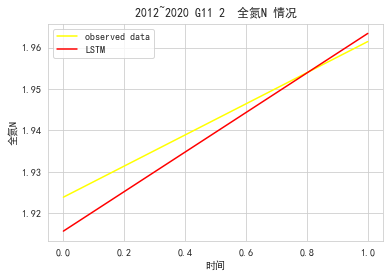

MAPE :
0.9952949933866574
RMSE :
0.09718422217840886
MAE :
0.09713500832322985


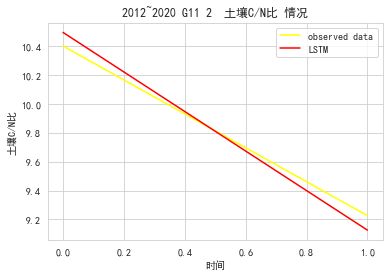

    SOC土壤有机碳   SIC土壤无机碳    STC土壤全碳       全氮N     土壤C/N比  土壤蒸发量(W/m2)  \
0  15.845344   8.216667  24.048819  1.609849  16.500021     8.950833   
1  13.318077  10.866667  24.184744  1.650528  15.753515     8.682500   
2  14.777000   9.819450  24.596450  1.712250  14.364988    11.865000   

      降水量(mm)  100cm湿度(kg/m2)  
0   72.890627       46.701667  
1  105.982500       50.712500  
2   33.062500       60.183164  
(2, 1, 8) (2, 8)
(2, 1, 8)
Epoch 1/200
1/1 - 2s - loss: 0.4646 - 2s/epoch - 2s/step
Epoch 2/200
1/1 - 0s - loss: 0.4623 - 6ms/epoch - 6ms/step
Epoch 3/200
1/1 - 0s - loss: 0.4601 - 5ms/epoch - 5ms/step
Epoch 4/200
1/1 - 0s - loss: 0.4577 - 6ms/epoch - 6ms/step
Epoch 5/200
1/1 - 0s - loss: 0.4551 - 6ms/epoch - 6ms/step
Epoch 6/200
1/1 - 0s - loss: 0.4524 - 7ms/epoch - 7ms/step
Epoch 7/200
1/1 - 0s - loss: 0.4495 - 6ms/epoch - 6ms/step
Epoch 8/200
1/1 - 0s - loss: 0.4465 - 6ms/epoch - 6ms/step
Epoch 9/200
1/1 - 0s - loss: 0.4432 - 5ms/epoch - 5ms/step
Epoch 10/200
1/1 - 0s - los

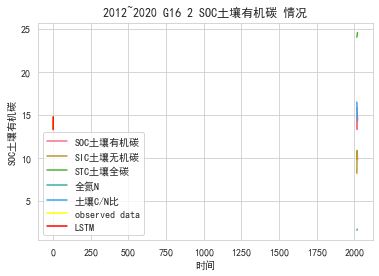

MAPE :
0.0471083259820636
RMSE :
0.00499324382687581
MAE :
0.004788273111978825


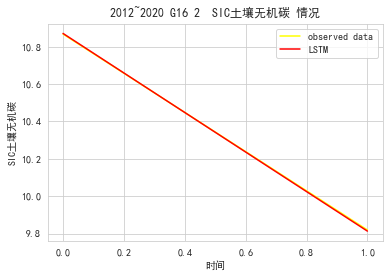

MAPE :
0.004676166005363755
RMSE :
0.0012932411742432438
MAE :
0.001135235532130352


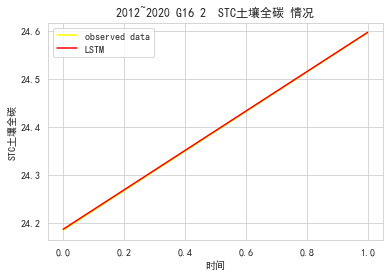

MAPE :
0.011318845432209472
RMSE :
0.00023753032327337293
MAE :
0.00018757495283938663


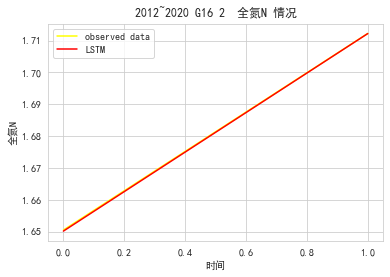

MAPE :
0.017289512094265325
RMSE :
0.0034118801194046393
MAE :
0.0024906324385334244


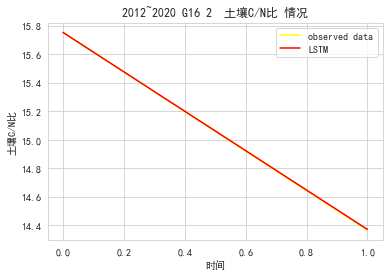

    SOC土壤有机碳  SIC土壤无机碳    STC土壤全碳       全氮N     土壤C/N比  土壤蒸发量(W/m2)  \
0  14.502588  7.783333  22.285921  1.836641  12.799613     8.950833   
1  15.855964  4.700000  20.555964  1.977365  10.667016     8.682500   
2  17.200000  3.122150  20.322150  2.236950   9.084758    11.865000   

      降水量(mm)  100cm湿度(kg/m2)  
0   72.890627       46.701667  
1  105.982500       50.712500  
2   33.062500       60.183164  
(2, 1, 8) (2, 8)
(2, 1, 8)
Epoch 1/200
1/1 - 2s - loss: 0.3609 - 2s/epoch - 2s/step
Epoch 2/200
1/1 - 0s - loss: 0.3589 - 6ms/epoch - 6ms/step
Epoch 3/200
1/1 - 0s - loss: 0.3569 - 5ms/epoch - 5ms/step
Epoch 4/200
1/1 - 0s - loss: 0.3548 - 5ms/epoch - 5ms/step
Epoch 5/200
1/1 - 0s - loss: 0.3525 - 6ms/epoch - 6ms/step
Epoch 6/200
1/1 - 0s - loss: 0.3502 - 6ms/epoch - 6ms/step
Epoch 7/200
1/1 - 0s - loss: 0.3477 - 7ms/epoch - 7ms/step
Epoch 8/200
1/1 - 0s - loss: 0.3449 - 5ms/epoch - 5ms/step
Epoch 9/200
1/1 - 0s - loss: 0.3420 - 7ms/epoch - 7ms/step
Epoch 10/200
1/1 - 0s - loss: 0

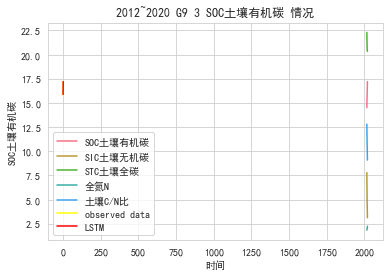

MAPE :
0.5632989380437712
RMSE :
0.02842512729976909
MAE :
0.024156622123718385


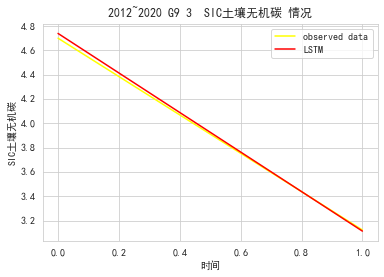

MAPE :
0.05201328152748167
RMSE :
0.01082418205076321
MAE :
0.010641988086700138


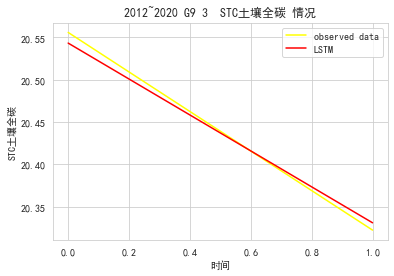

MAPE :
0.0387779340455502
RMSE :
0.0008218726718597242
MAE :
0.0008185556173321284


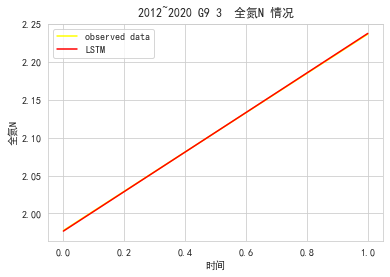

MAPE :
0.10794662433284037
RMSE :
0.011606654271466482
MAE :
0.01090962913329463


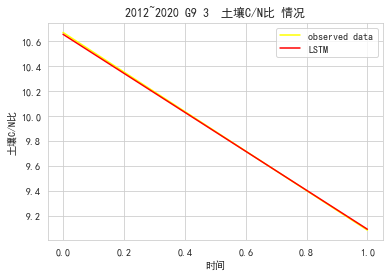

    SOC土壤有机碳  SIC土壤无机碳    STC土壤全碳       全氮N     土壤C/N比  土壤蒸发量(W/m2)  \
0  15.968152  5.333333  21.301485  1.882645  11.844474     8.950833   
1  15.033399  5.650000  20.683399  1.906732  11.251682     8.682500   
2  16.691900  3.564700  20.256600  2.102850   9.632927    11.865000   

      降水量(mm)  100cm湿度(kg/m2)  
0   72.890627       46.701667  
1  105.982500       50.712500  
2   33.062500       60.183164  
(2, 1, 8) (2, 8)
(2, 1, 8)
Epoch 1/200
1/1 - 2s - loss: 0.4253 - 2s/epoch - 2s/step
Epoch 2/200
1/1 - 0s - loss: 0.4234 - 6ms/epoch - 6ms/step
Epoch 3/200
1/1 - 0s - loss: 0.4216 - 6ms/epoch - 6ms/step
Epoch 4/200
1/1 - 0s - loss: 0.4198 - 5ms/epoch - 5ms/step
Epoch 5/200
1/1 - 0s - loss: 0.4180 - 6ms/epoch - 6ms/step
Epoch 6/200
1/1 - 0s - loss: 0.4161 - 10ms/epoch - 10ms/step
Epoch 7/200
1/1 - 0s - loss: 0.4141 - 9ms/epoch - 9ms/step
Epoch 8/200
1/1 - 0s - loss: 0.4120 - 8ms/epoch - 8ms/step
Epoch 9/200
1/1 - 0s - loss: 0.4097 - 8ms/epoch - 8ms/step
Epoch 10/200
1/1 - 0s - loss:

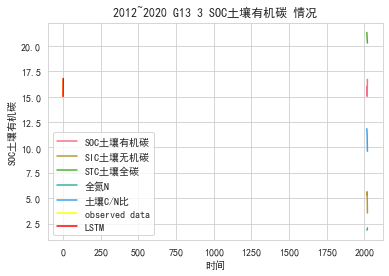

MAPE :
5.062045647751588
RMSE :
0.24704422955865996
MAE :
0.18396891727447495


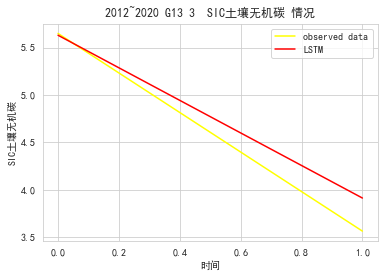

MAPE :
0.010488543802944266
RMSE :
0.0026049363575796724
MAE :
0.00213115536370978


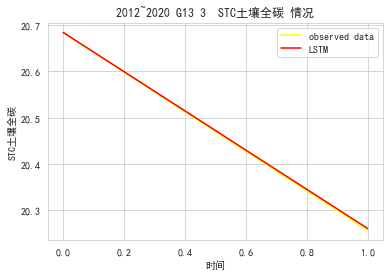

MAPE :
0.4144764902841698
RMSE :
0.011874140754971911
MAE :
0.008685536714394093


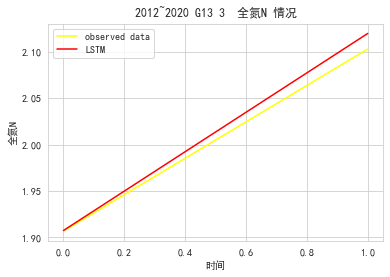

MAPE :
1.0730228807612916
RMSE :
0.14587317934946642
MAE :
0.10339978906404923


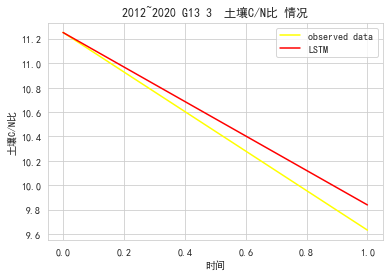

   SOC土壤有机碳  SIC土壤无机碳    STC土壤全碳       全氮N     土壤C/N比  土壤蒸发量(W/m2)  \
0  14.28423  7.727778  22.012008  1.918901  12.394791     8.950833   
1  16.04489  6.466667  22.511557  1.953936  12.078220     8.682500   
2  15.96960  4.657050  20.626650  2.054600  10.039253    11.865000   

      降水量(mm)  100cm湿度(kg/m2)  
0   72.890627       46.701667  
1  105.982500       50.712500  
2   33.062500       60.183164  
(2, 1, 8) (2, 8)
(2, 1, 8)
Epoch 1/200
1/1 - 4s - loss: 0.5109 - 4s/epoch - 4s/step
Epoch 2/200
1/1 - 0s - loss: 0.5090 - 7ms/epoch - 7ms/step
Epoch 3/200
1/1 - 0s - loss: 0.5075 - 8ms/epoch - 8ms/step
Epoch 4/200
1/1 - 0s - loss: 0.5059 - 7ms/epoch - 7ms/step
Epoch 5/200
1/1 - 0s - loss: 0.5042 - 10ms/epoch - 10ms/step
Epoch 6/200
1/1 - 0s - loss: 0.5024 - 11ms/epoch - 11ms/step
Epoch 7/200
1/1 - 0s - loss: 0.5006 - 9ms/epoch - 9ms/step
Epoch 8/200
1/1 - 0s - loss: 0.4986 - 9ms/epoch - 9ms/step
Epoch 9/200
1/1 - 0s - loss: 0.4966 - 10ms/epoch - 10ms/step
Epoch 10/200
1/1 - 0s - loss:

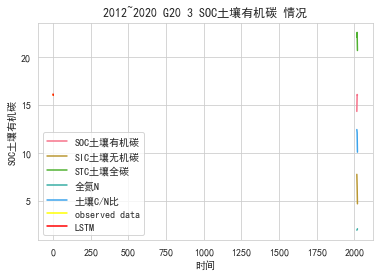

MAPE :
0.724272852915838
RMSE :
0.04223010851617905
MAE :
0.04091686922709181


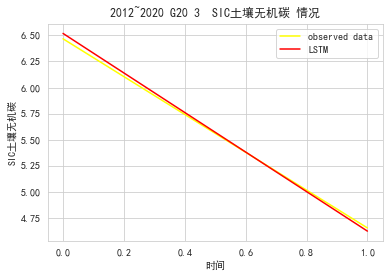

MAPE :
0.10096456688923088
RMSE :
0.0238279861280393
MAE :
0.02212239522934034


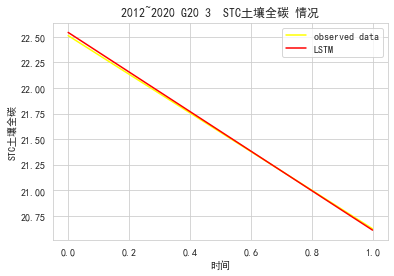

MAPE :
0.009721719163185328
RMSE :
0.00019628796560303843
MAE :
0.0001952360649895013


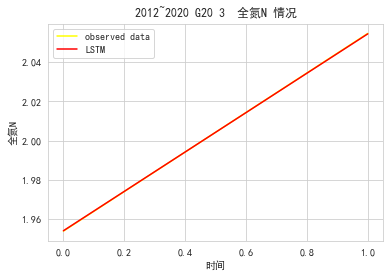

MAPE :
0.2375276533821548
RMSE :
0.029202821189937184
MAE :
0.027057185841204756


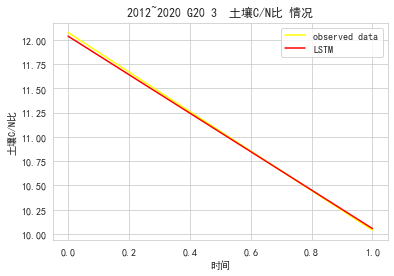

CPU times: total: 42.5 s
Wall time: 1min 19s


In [8]:
%%time
Q(Q3 = True)

In [9]:
%%time
Q(Q4 = True)

C:\Users\11958\AppData\Local\Temp\ipykernel_26388\2784916161.py:407: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[i]=(data[i]-data[i].min())/(data[i].max()-data[i].min())
C:\Users\11958\AppData\Local\Temp\ipykernel_26388\2784916161.py:408: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[ '10cm湿度(kg/m2)']=1/3*data[ '10cm湿度(kg/m2)']
C:\Users\11958\AppData\Local\Temp\ipykernel_26388\2784916161.py:409: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

[0.65203212]
[0.55822559]


C:\Users\11958\AppData\Local\Temp\ipykernel_26388\2784916161.py:433: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[i]=(data[i]-data[i].min())/(data[i].max()-data[i].min())


[0.68995241]
[0.79709561]
      月份    年份 放牧小区（plot） 放牧强度（intensity）   SOC土壤有机碳  SIC土壤无机碳    STC土壤全碳  \
24     1  2012        G21              NG  14.549908    9.6000  24.149908   
25     2  2012        G21              NG  14.549908    9.6000  24.149908   
26     3  2012        G21              NG  14.549908    9.6000  24.149908   
27     4  2012        G21              NG  14.549908    9.6000  24.149908   
28     5  2012        G21              NG  14.549908    9.6000  24.149908   
...   ..   ...        ...             ...        ...       ...        ...   
1471   8  2020        G21              NG  20.133500    4.0649  24.198400   
1472   9  2020        G21              NG  20.133500    4.0649  24.198400   
1473  10  2020        G21              NG  20.133500    4.0649  24.198400   
1474  11  2020        G21              NG  20.133500    4.0649  24.198400   
1475  12  2020        G21              NG  20.133500    4.0649  24.198400   

           全氮N     土壤C/N比  10cm湿度(kg/m2)  40cm湿度(

C:\Users\11958\AppData\Local\Temp\ipykernel_26388\2784916161.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[i]=(data[i]-data[i].min())/(data[i].max()-data[i].min())


     月份    年份  10cm湿度(kg/m2)  200cm湿度(kg/m2)  植被指数(NDVI)   平均气温(℃)   降水量(mm)  \
0     1  2012       0.328250        1.000000    0.030547  0.008070  0.002568   
1     2  2012       0.269663        1.000000    0.030547  0.113180  0.002568   
2     3  2012       0.237560        1.000000    0.220257  0.335609  0.024490   
3     4  2012       0.186998        1.000000    0.297428  0.626319  0.006840   
4     5  2012       0.364366        1.000000    0.340836  0.785020  0.056964   
..   ..   ...            ...             ...         ...       ...       ...   
118  11  2021       0.342697        0.002451    0.411576  0.360852  0.595275   
119  12  2021       0.280899        0.000000    0.069132  0.225947  0.217316   
120   1  2022       0.225522        0.000000    0.043408  0.129112  0.681001   
121   2  2022       0.197432        0.000000    0.043408  0.111732  0.892632   
122   3  2022       0.426966        0.000000    0.327974  0.433892  0.129593   

     平均风速(knots)  
0       0.216981  
1

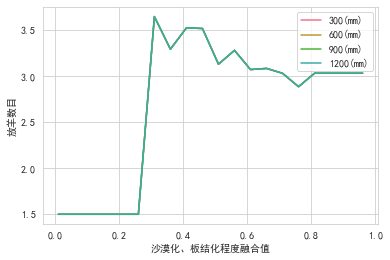

CPU times: total: 7.19 s
Wall time: 1.79 s


In [10]:
%%time
Q(Q5 = True)

ls = [['放牧方式__轻牧（3天）', 0.35733942835548865], ['放牧方式__重牧（12天）', 0.33116801699083614], ['放牧方式__无牧（0天）', 0.3114925546536753], ['SOC土壤有机碳', 0.0], ['SIC土壤无机碳', 0.0], ['STC土壤全碳', 0.0], ['全氮N', 0.0], ['土壤C/N比', 0.0], ['株/丛数', 0.0], ['鲜重(g)', 0.0], ['干重(g)', 0.0], ['plot__G11', 0.0], ['plot__G12', 0.0], ['plot__G13', 0.0], ['plot__G16', 0.0], ['plot__G17', 0.0], ['plot__G18', 0.0], ['plot__G19', 0.0], ['plot__G20', 0.0], ['plot__G21', 0.0], ['plot__G6', 0.0], ['plot__G8', 0.0], ['plot__G9', 0.0], ['轮次__牧前', 0.0], ['轮次__第一轮牧后', 0.0], ['轮次__第三轮牧后', 0.0], ['轮次__第二轮牧后', 0.0], ['轮次__第四轮牧后', 0.0], ['放牧方式__中牧（6天）', 0.0], ['植物功能群__AB', 0.0], ['植物功能群__PB', 0.0], ['植物功能群__PF', 0.0], ['植物功能群__PR', 0.0], ['月份', 0.0], ['10cm湿度(kg/m2)', 0.0], ['200cm湿度(kg/m2)', 0.0], ['土壤蒸发量(W/m2)', 0.0], ['径流量(m3/s)', 0.0], ['植被指数(NDVI)', 0.0], ['平均气温(℃)', 0.0], ['降水量(mm)', 0.0], ['平均风速(knots)', 0.0]]
sort_num = 10
ls = np.array(ls)
value_x = [round(float(x),3) for x in ls[:sort_num,1]]
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.barh(range(sort_num),value_x,tick_label = ls[:sort_num,0])
plt.savefig('temp_img/importance_features_q1')
plt.show()

![](2.jpg)

其中k需要求解,与LAI相关.  Rcum 累计降雨量


草地的植被直接决定放牧的强度，而植被的截流量能最好反映植被的生长能力，依照递推关系，放牧强度与植被的截流量存在正相关关系.